# MIPT BioTechDays 2022

In [54]:
import pandas as pd 
import numpy  as np
import mne #for .edf preprocessing
import heartpy #reference comparison 
import matplotlib.pyplot as plt
import wfdb #for .atr .dat preprocessing
from scipy.fft import fft, ifft, rfft, fftfreq, rfftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### EEG and ECG During Mental Arithmetic Tasks

In [7]:
#high-pass filter
def hpf(x, param = 0.0004):
	y = x.copy()
	
	for n in range(x.shape[0]):
		if(x[n] < param):
			continue
		y.iloc[n] = 2 * y.iloc[n - 1] - y.iloc[n - 2] + x.iloc[n ] - 2 * x.iloc[n - 6] + x.iloc[n - 12] 
	return y

#low-pass filter
def lpf(x, param = 0.0004):
	y = x.copy()
	
	for n in range(x.shape[0]):
		if(x[n] < param):
			continue
		y.iloc[n] = y.iloc[n - 1] - x.iloc[n]/32 + x.iloc[n - 16] - x.iloc[n - 17] + x.iloc[n - 32]/32
	return y

#derrivative of signal
def deriv(x, param = 0.0004):
	y = x.copy()

	for n in range(x.shape[0]):
		if(x[n] < param):
			continue
		y.iloc[n] = (2 * x.iloc[n] + x.iloc[n-1] - x.iloc[n - 3] - 2 * x.iloc[n - 4])/4
	return y

def standard_normalize(x):
	normalizer = StandardScaler()
	normalizer.fit(x)
	return normalizer.transform(x)


def minMax_normalize(x):
	normalizer = MinMaxScaler()
	normalizer.fit(x)
	return normalizer.transform(x)

In [9]:
file       = 'eeg-during-mental-arithmetic-tasks-1.0.0/Subject{0}_{1}.edf'
indexes    = ['00', '01', '02', '03', '05', '06', '07', '08', '09', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35']

data_arithmetic = pd.DataFrame(columns = indexes, data=np.zeros([91000, 33]))
pure_arithmetic = pd.DataFrame(columns = indexes, data=np.zeros([91000, 33]))

for i in indexes:
        data       = mne.io.read_raw_edf(file.format(i, '1'))
        raw_data   = np.array(data.get_data())[20]
        #print(i, raw_data.shape)
        channels   = np.array(data.ch_names)
        data_arithmetic[i] = minMax_normalize(raw_data.reshape(-1, 1))
        pure_arithmetic[i] = raw_data
        info       = data.info

None

Extracting EDF parameters from c:\Users\egorm\OneDrive\Документы\bio_tech\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\egorm\OneDrive\Документы\bio_tech\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\egorm\OneDrive\Документы\bio_tech\eeg-during-mental-arithmetic-tasks-1.0.0\Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\egorm\OneDrive\Документы\bio_tech\eeg-during-mental-arithmetic-tasks-1.0.0\Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\egorm\OneDrive\Документы\bio_tech\eeg-during-mental-arithmetic-tasks-1.0.0\Subject05_1.edf..

In [11]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2010-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
>

In [12]:
data_arithmetic.shape

(91000, 33)

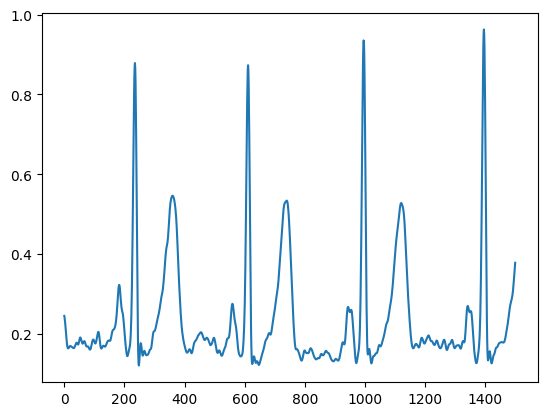

In [13]:
minMax_dat = data_arithmetic['00'].to_numpy().reshape(-1, 1)
minMax_dat = minMax_dat[:1500]
#plt.plot(stand_dat) 
plt.plot(minMax_dat) 
plt.show()
None

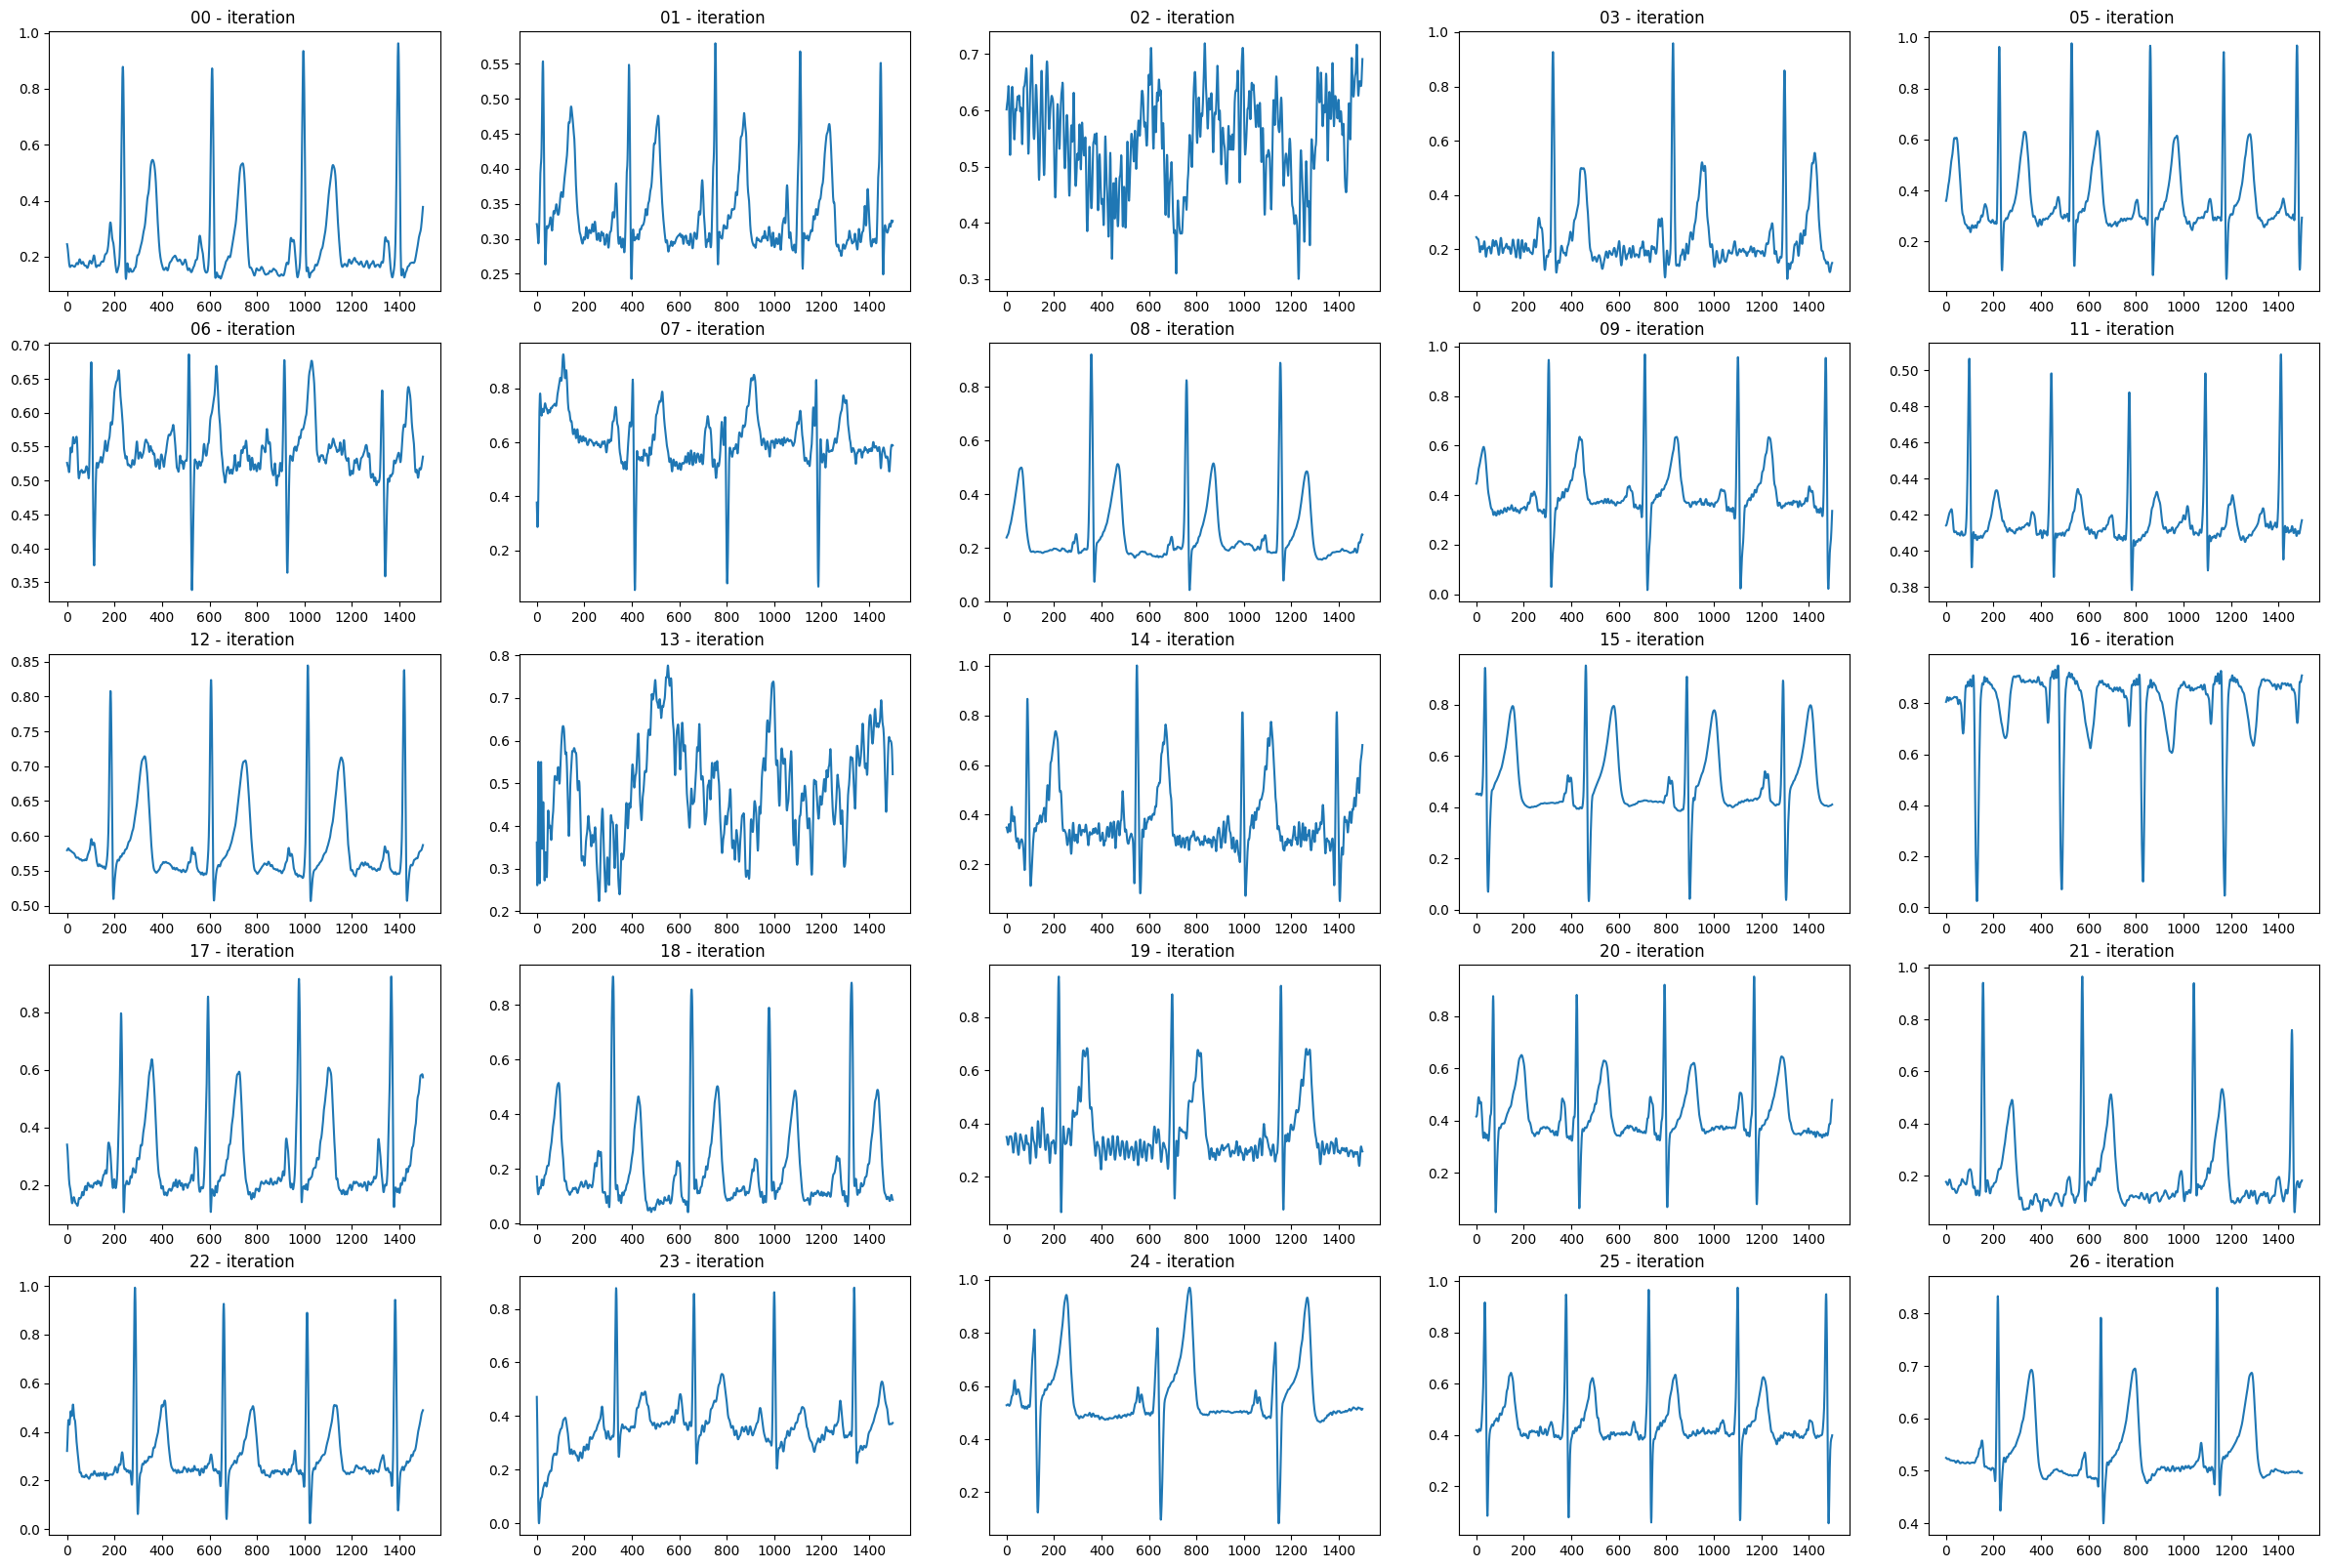

In [14]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 5, ncols = 5)

for i in range(25):
    ax[(i - 25 )// 5][(i - 25 ) % 5].plot(data_arithmetic[indexes[i]][:1500].to_numpy())
    ax[(i - 25 ) // 5][(i - 25 ) % 5].set_title(indexes[i] + ' - iteration ')

IndexError: list index out of range

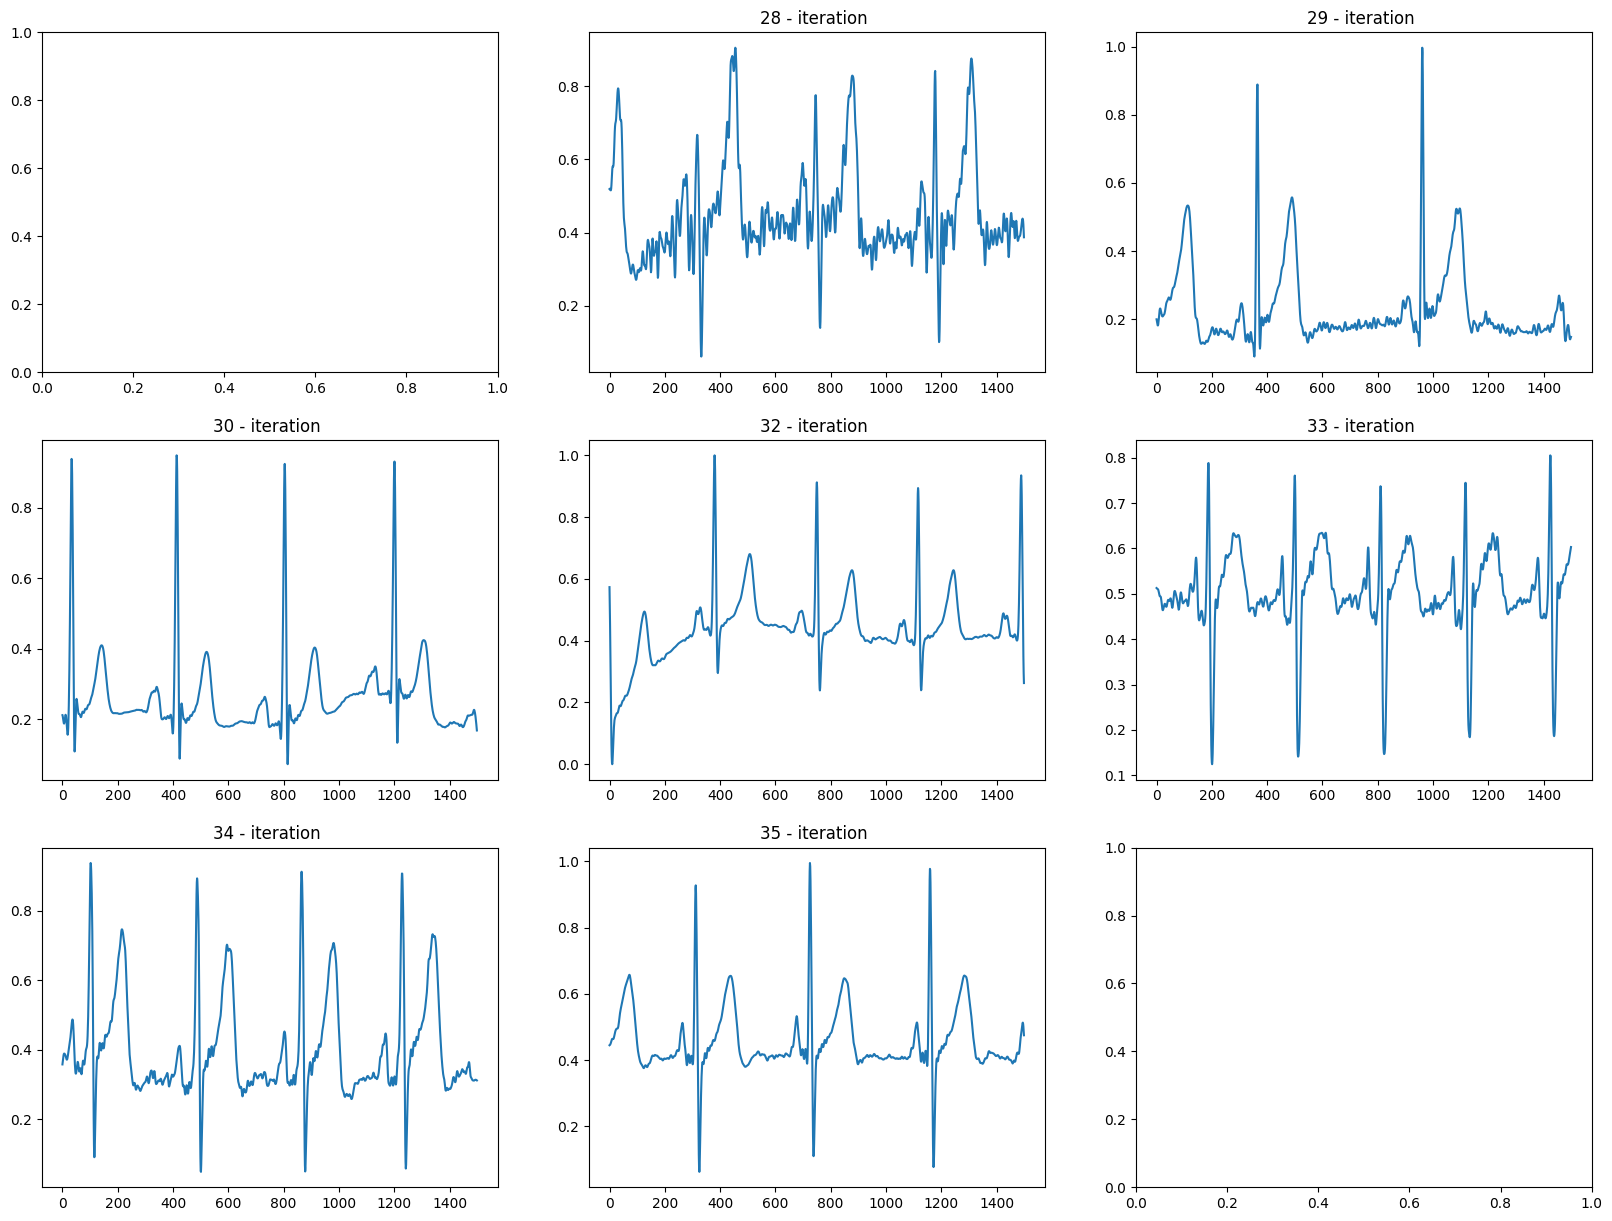

In [15]:
fig, ax = plt.subplots(figsize = (20, 15), nrows = 3, ncols = 3)

for i in range(26, 48):
    if i > len(indexes): 
        pass
    else:
        ax[(i - 25)// 3][(i - 25 ) % 3].plot(data_arithmetic[indexes[i]][:1500].to_numpy())
        ax[(i - 25)// 3][(i - 25 ) % 3].set_title(indexes[i] + ' - iteration ')

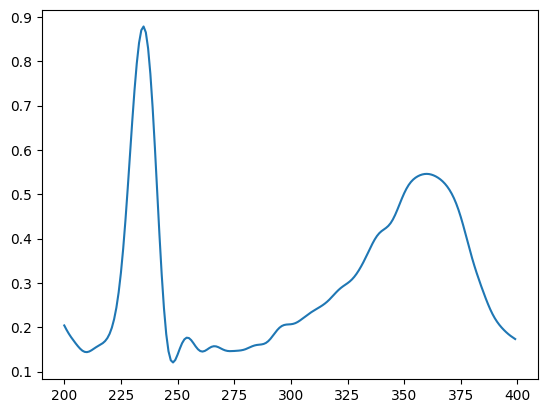

In [17]:
plt.plot(data_arithmetic['00'][200:400])

Kinda pointless to waste time trying handle graphs like `13`, `07`, `02`, `16`, `24`, `28`, so let's analyse data set without lower-peaks and too much noise 

In [18]:
nice_indexes = ['00', '01', '03', '05', '06', '08', '09', '11', '12', '14', '15', '17', '18', '19', '20', '21', '22', '23', '25', '26', '27', '29', '30', '32', '33', '34', '35']

In [19]:
real_times  = np.array([])

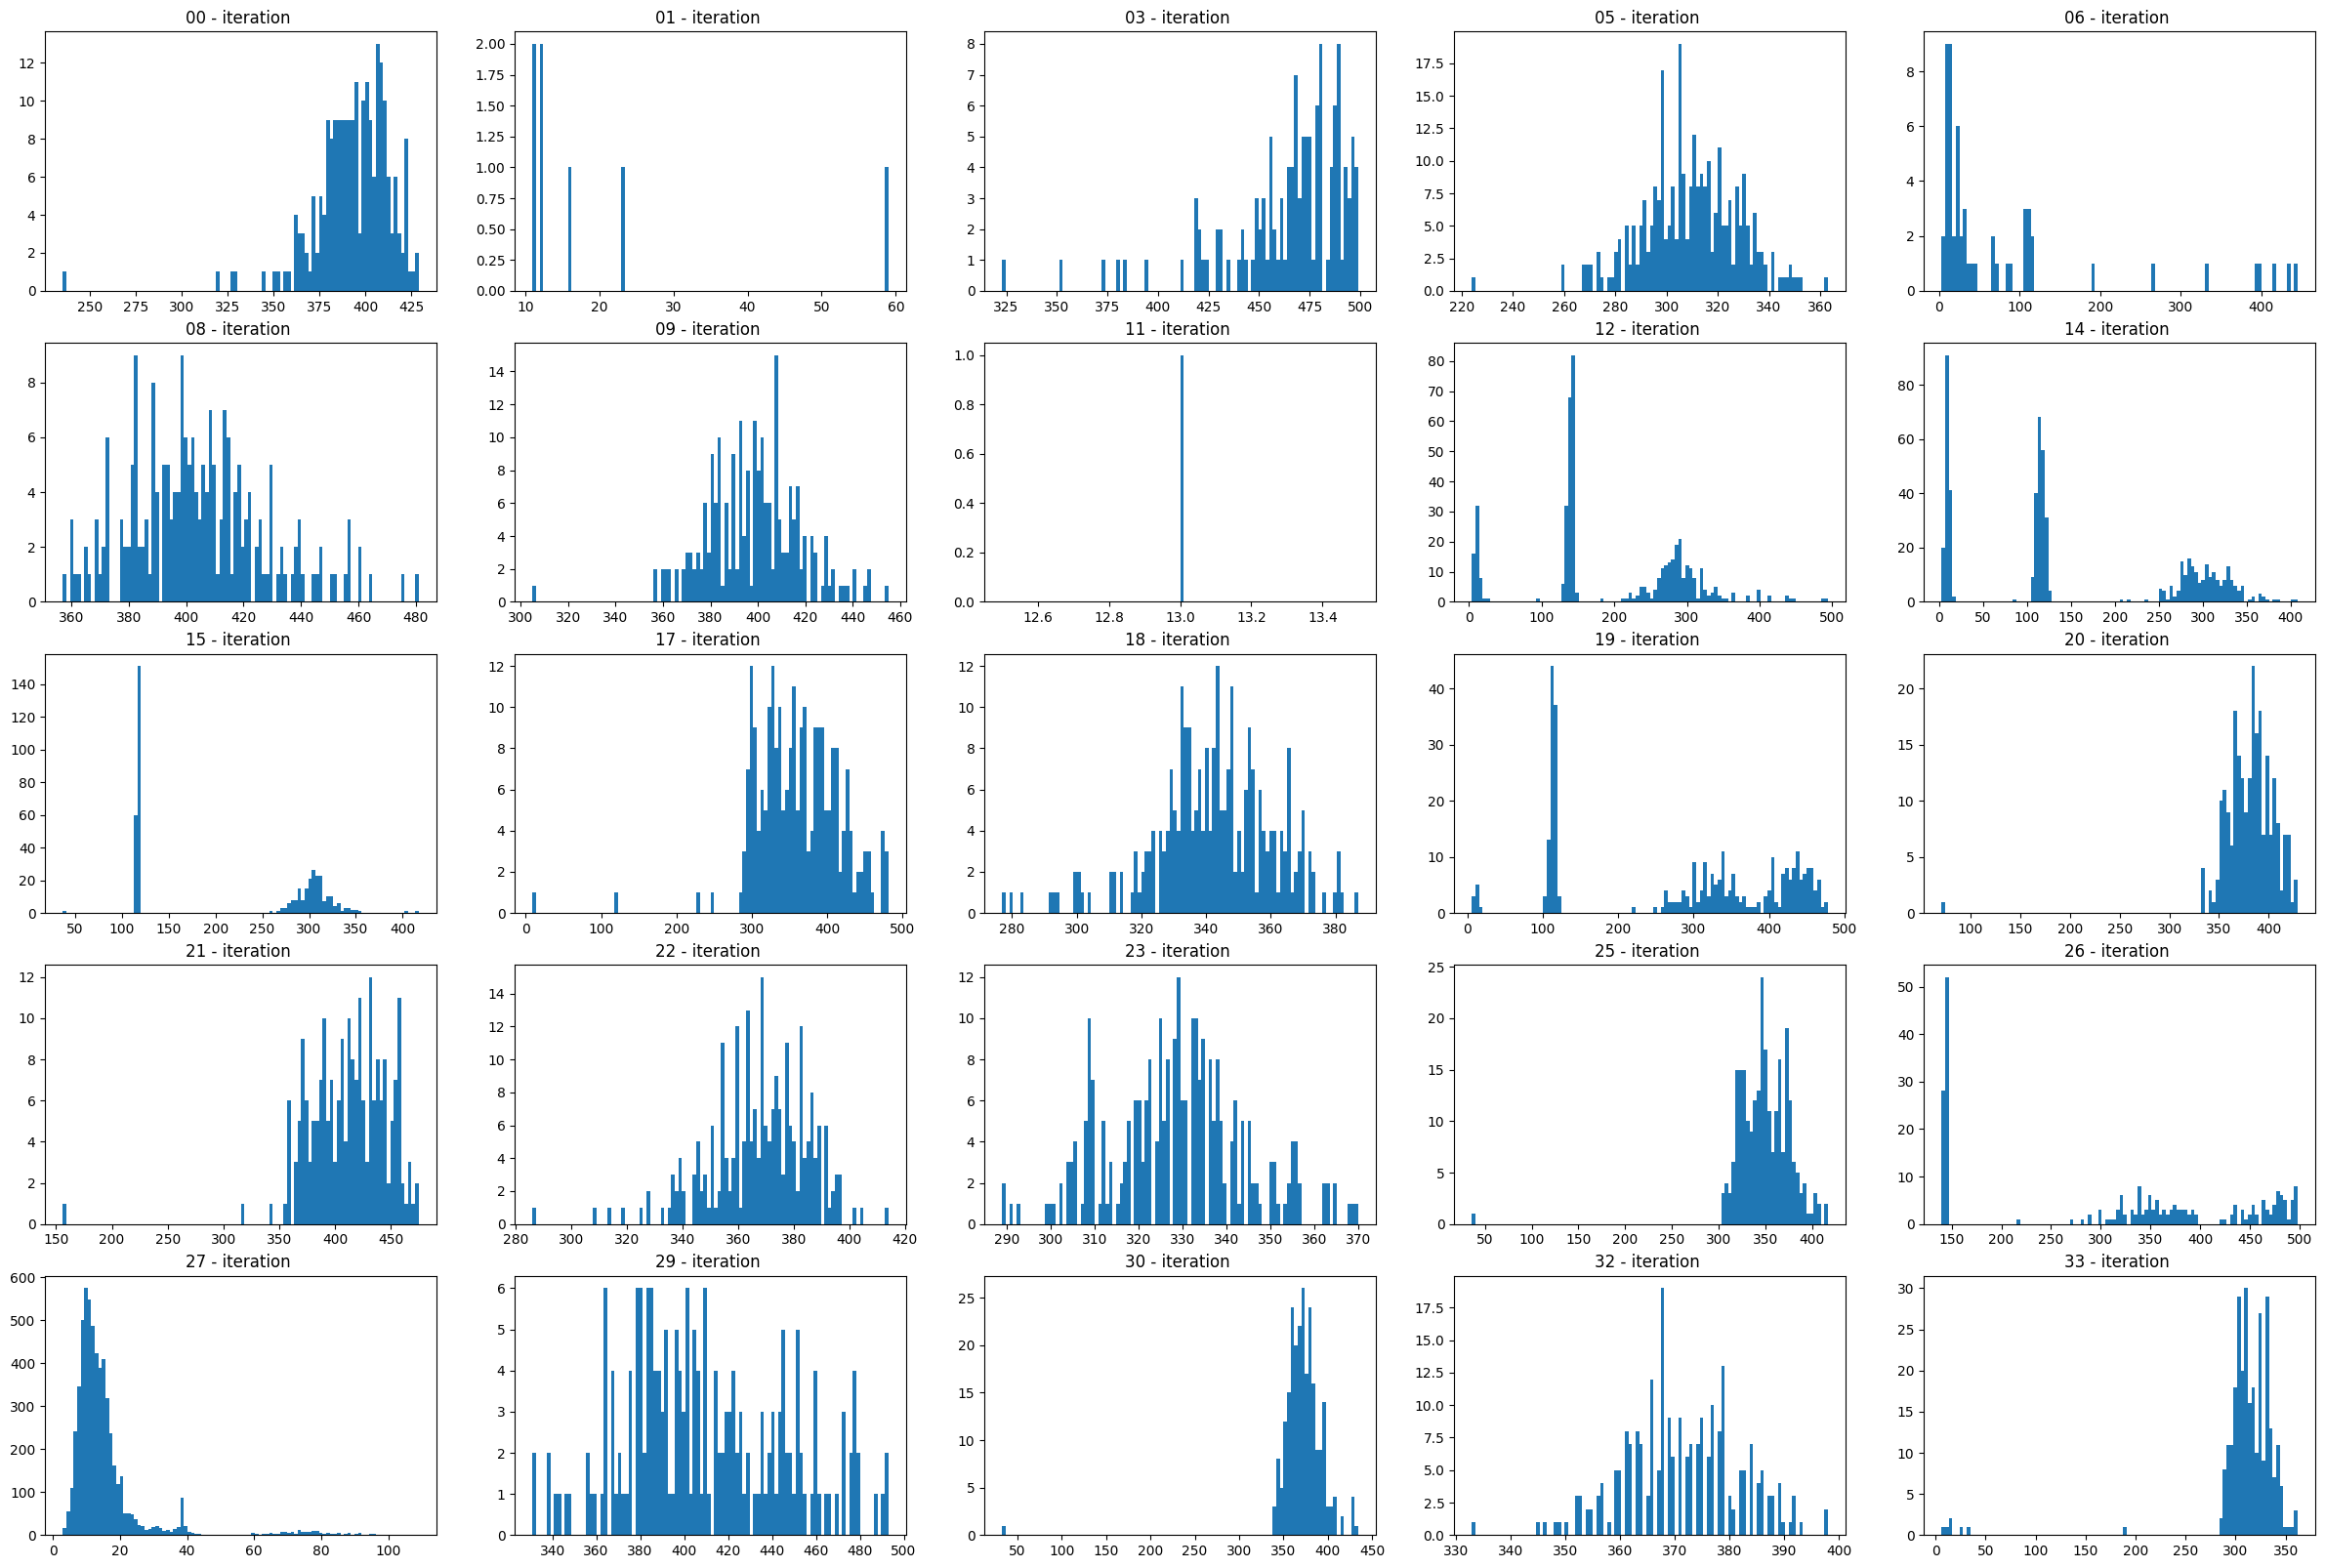

In [106]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 5, ncols = 5)

for counter, k in enumerate(nice_indexes):

    times = data_arithmetic[k]
    delta_times = np.array([])
    for i in range(1, 90999):
        if (times[i] > times[i + 1]) and (times[i] > times[i - 1]) and (times[i] > 0.7):
            delta_times = np.append(delta_times, i)
    #print("TEST {0}: ".format(k))
    delta_times -= np.concatenate(([0], delta_times[:-1]))
    delta_times = delta_times[delta_times < 500]
    
    if counter < 25:
        ax[counter // 5][(counter) % 5].hist(delta_times, bins = 100)
        ax[counter // 5][(counter) % 5].set_title(nice_indexes[counter] + ' - iteration ')

    real_times = np.append(real_times, delta_times[delta_times > 150])


Those strange graphs like `01`, `06`, `12`, `19` ,`26`, were got due to incorrect time snippet interpretation

In [107]:
nice_indexes_2 = ['00', '03', '05', '08', '09', '14', '11', '15', '17', '18', '20', '21', '22', '23', '25', '27', '29', '30', '32', '33', '34', '35']

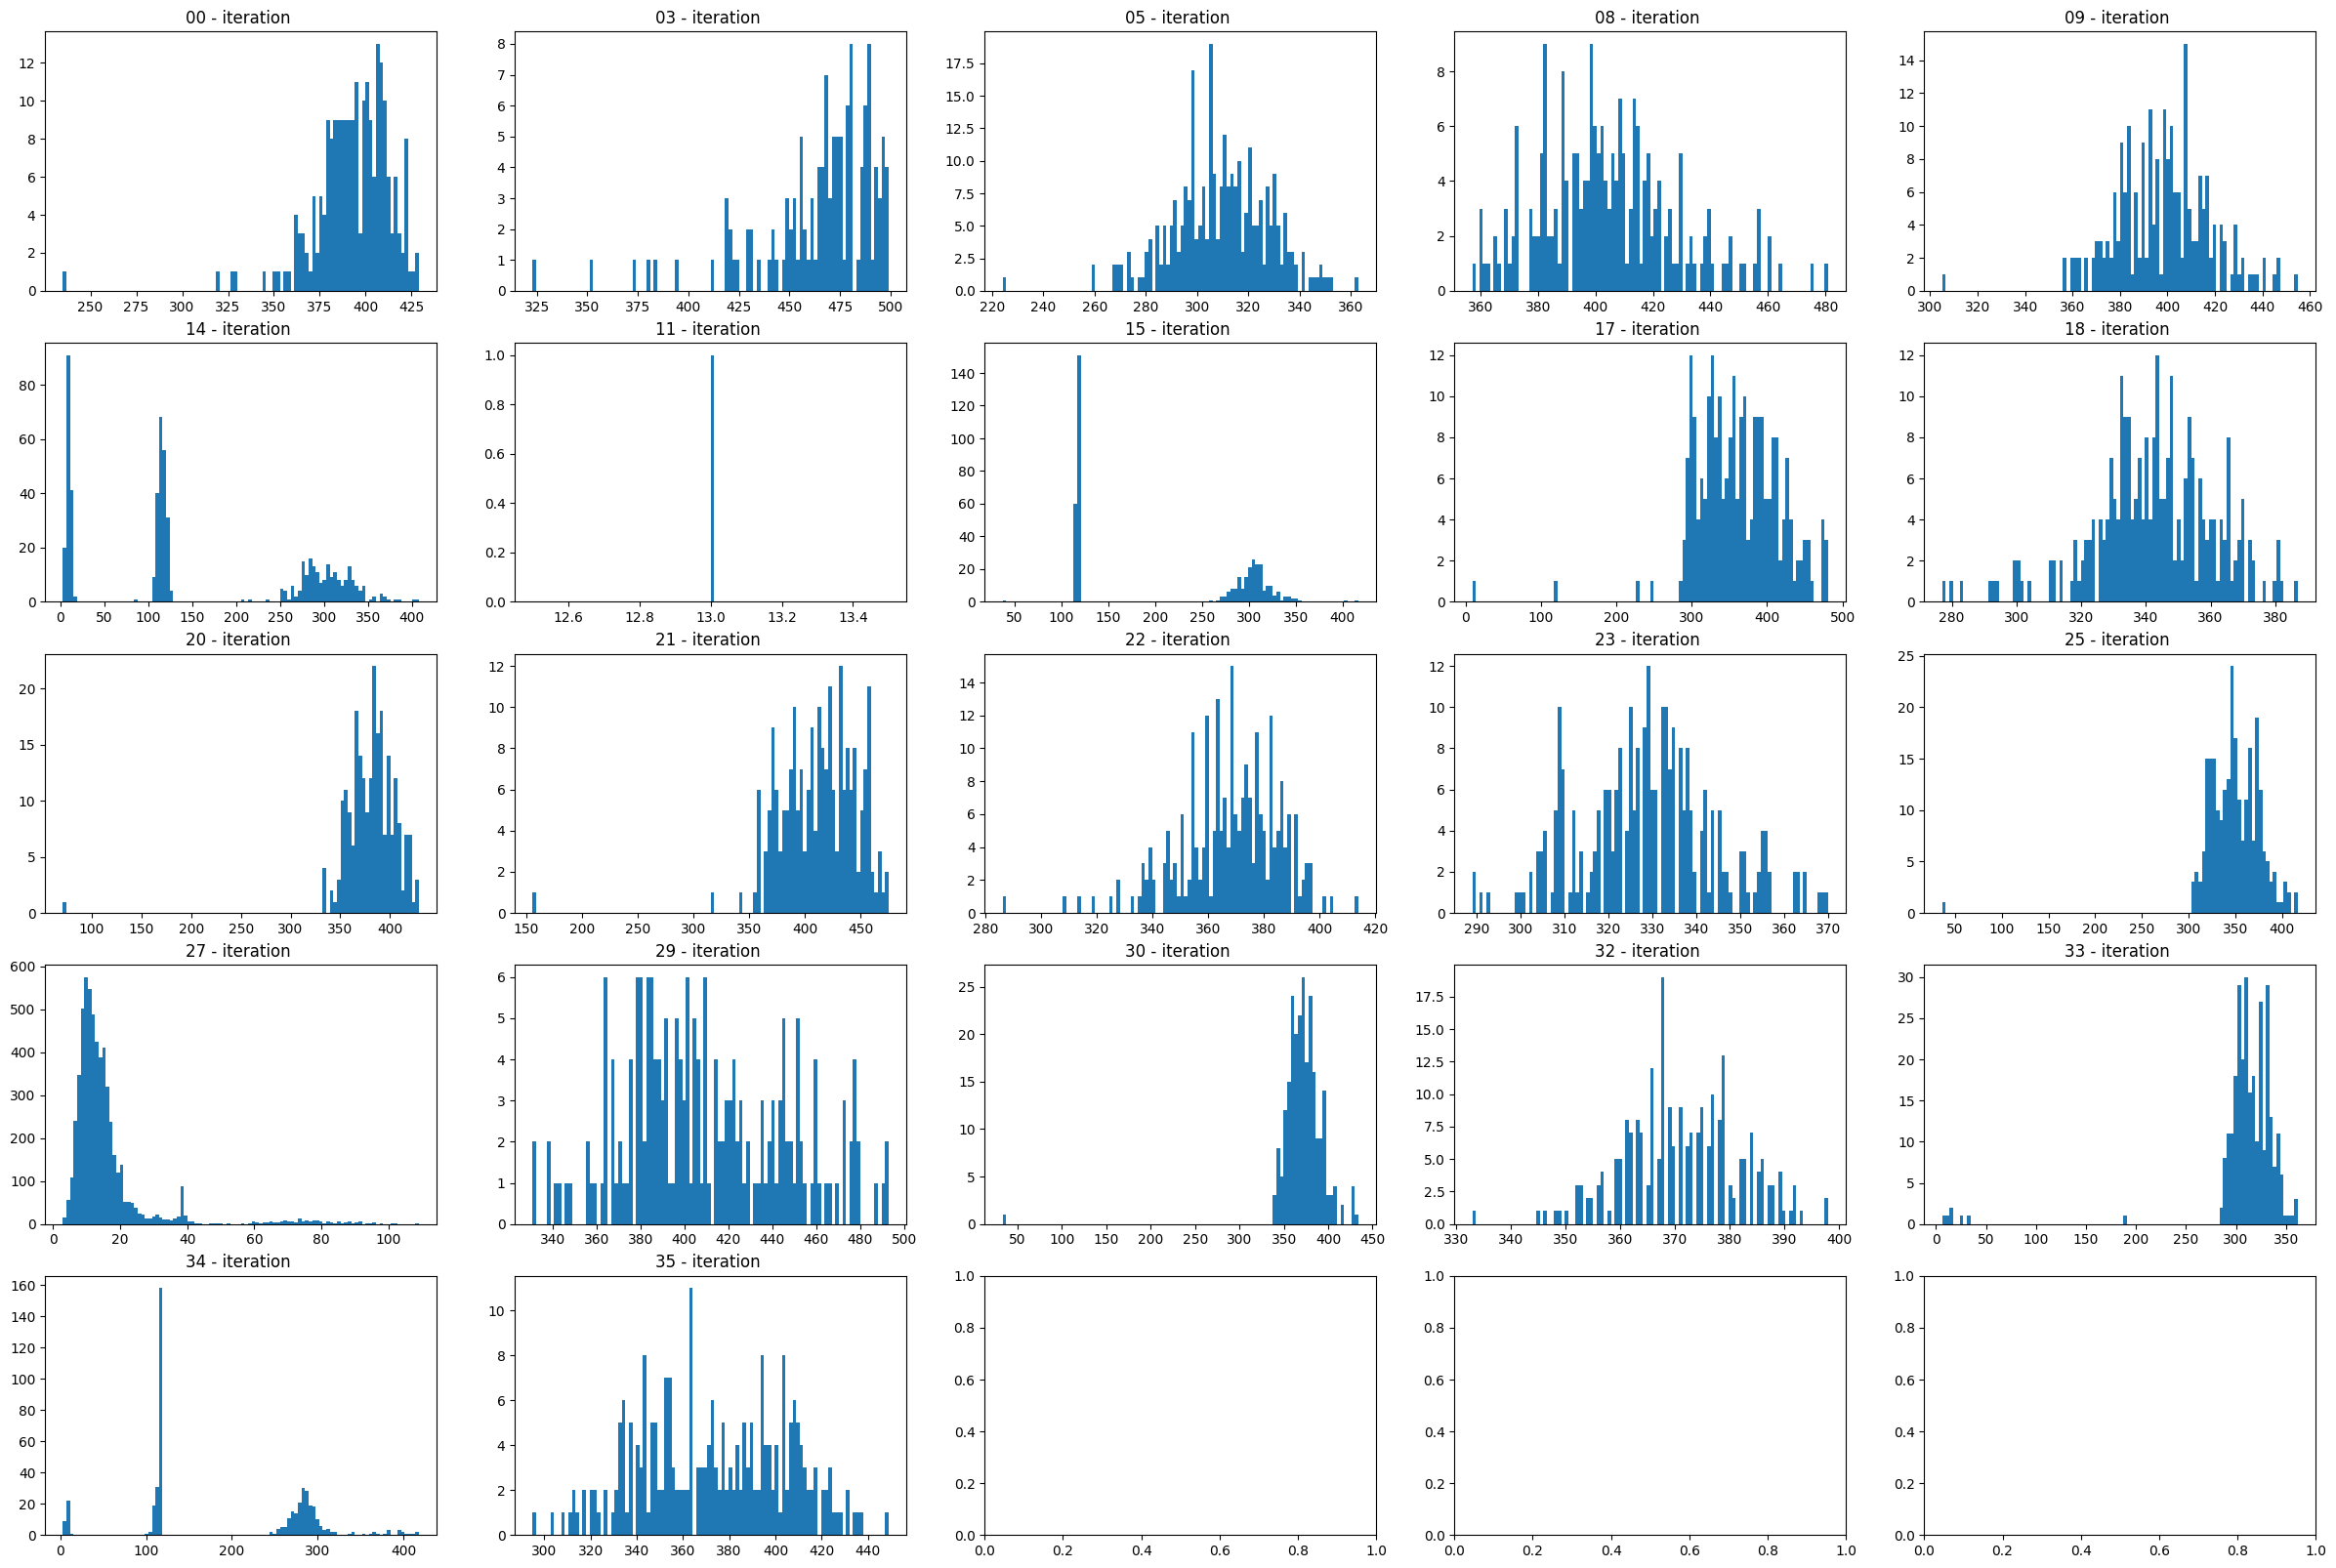

In [108]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 5, ncols = 5)
real_times = []

for counter, k in enumerate(nice_indexes_2):

    times = data_arithmetic[k]
    delta_times = np.array([])
    for i in range(1, 90999):
        if (times[i] > times[i + 1]) and (times[i] > times[i - 1]) and (times[i] > 0.7):
            delta_times = np.append(delta_times, i)
    #print("TEST {0}: ".format(k))
    delta_times -= np.concatenate(([0], delta_times[:-1]))
    delta_times = delta_times[delta_times < 500]
    
    if counter < 25:
        ax[counter // 5][(counter) % 5].hist(delta_times, bins = 100)
        ax[counter // 5][(counter) % 5].set_title(nice_indexes_2[counter] + ' - iteration ')
        
    real_times = np.append(real_times, delta_times)


In [109]:
real_times = real_times[real_times > 200] / 500

(array([  1.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   2.,   0.,
          0.,   1.,   2.,   0.,   5.,   6.,   7.,   9.,  10.,  12.,  17.,
         17.,  30.,  22.,  41.,  47.,  50.,  60.,  60.,  60.,  73.,  73.,
        100.,  92.,  94.,  77.,  40.,  79.,  86.,  92., 105.,  99., 115.,
         81.,  78.,  88.,  79.,  78.,  52.,  86.,  96.,  99., 117., 120.,
        141., 127.,  98., 130., 117., 131., 108.,  68.,  93.,  89.,  83.,
         87.,  70.,  87.,  68.,  61.,  59.,  39.,  51.,  28.,  19.,  26.,
         24.,  18.,  23.,  11.,  18.,  17.,  18.,  17.,  20.,  12.,   6.,
         10.,  12.,  13.,  14.,  15.,  15.,   1.,   7.,  13.,   7.,   4.,
          8.]),
 array([0.414  , 0.41984, 0.42568, 0.43152, 0.43736, 0.4432 , 0.44904,
        0.45488, 0.46072, 0.46656, 0.4724 , 0.47824, 0.48408, 0.48992,
        0.49576, 0.5016 , 0.50744, 0.51328, 0.51912, 0.52496, 0.5308 ,
        0.53664, 0.54248, 0.54832, 0.55416, 0.56   , 0.56584, 0.57168,
        0.57752, 0.58336, 0.5892 ,

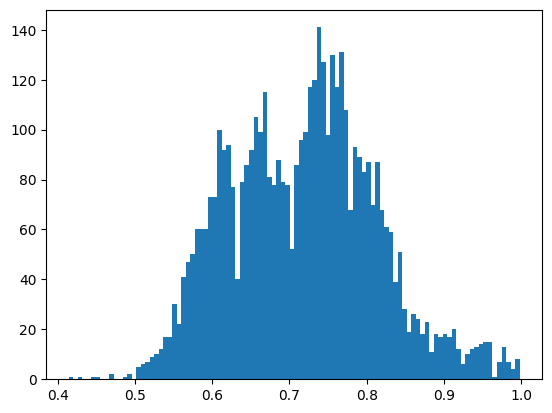

In [110]:
plt.hist(real_times, bins = 100)

#### Fast-Fourier Transform

#### Furiet peaks, HF: 0,15–0,4 Hz

c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values t

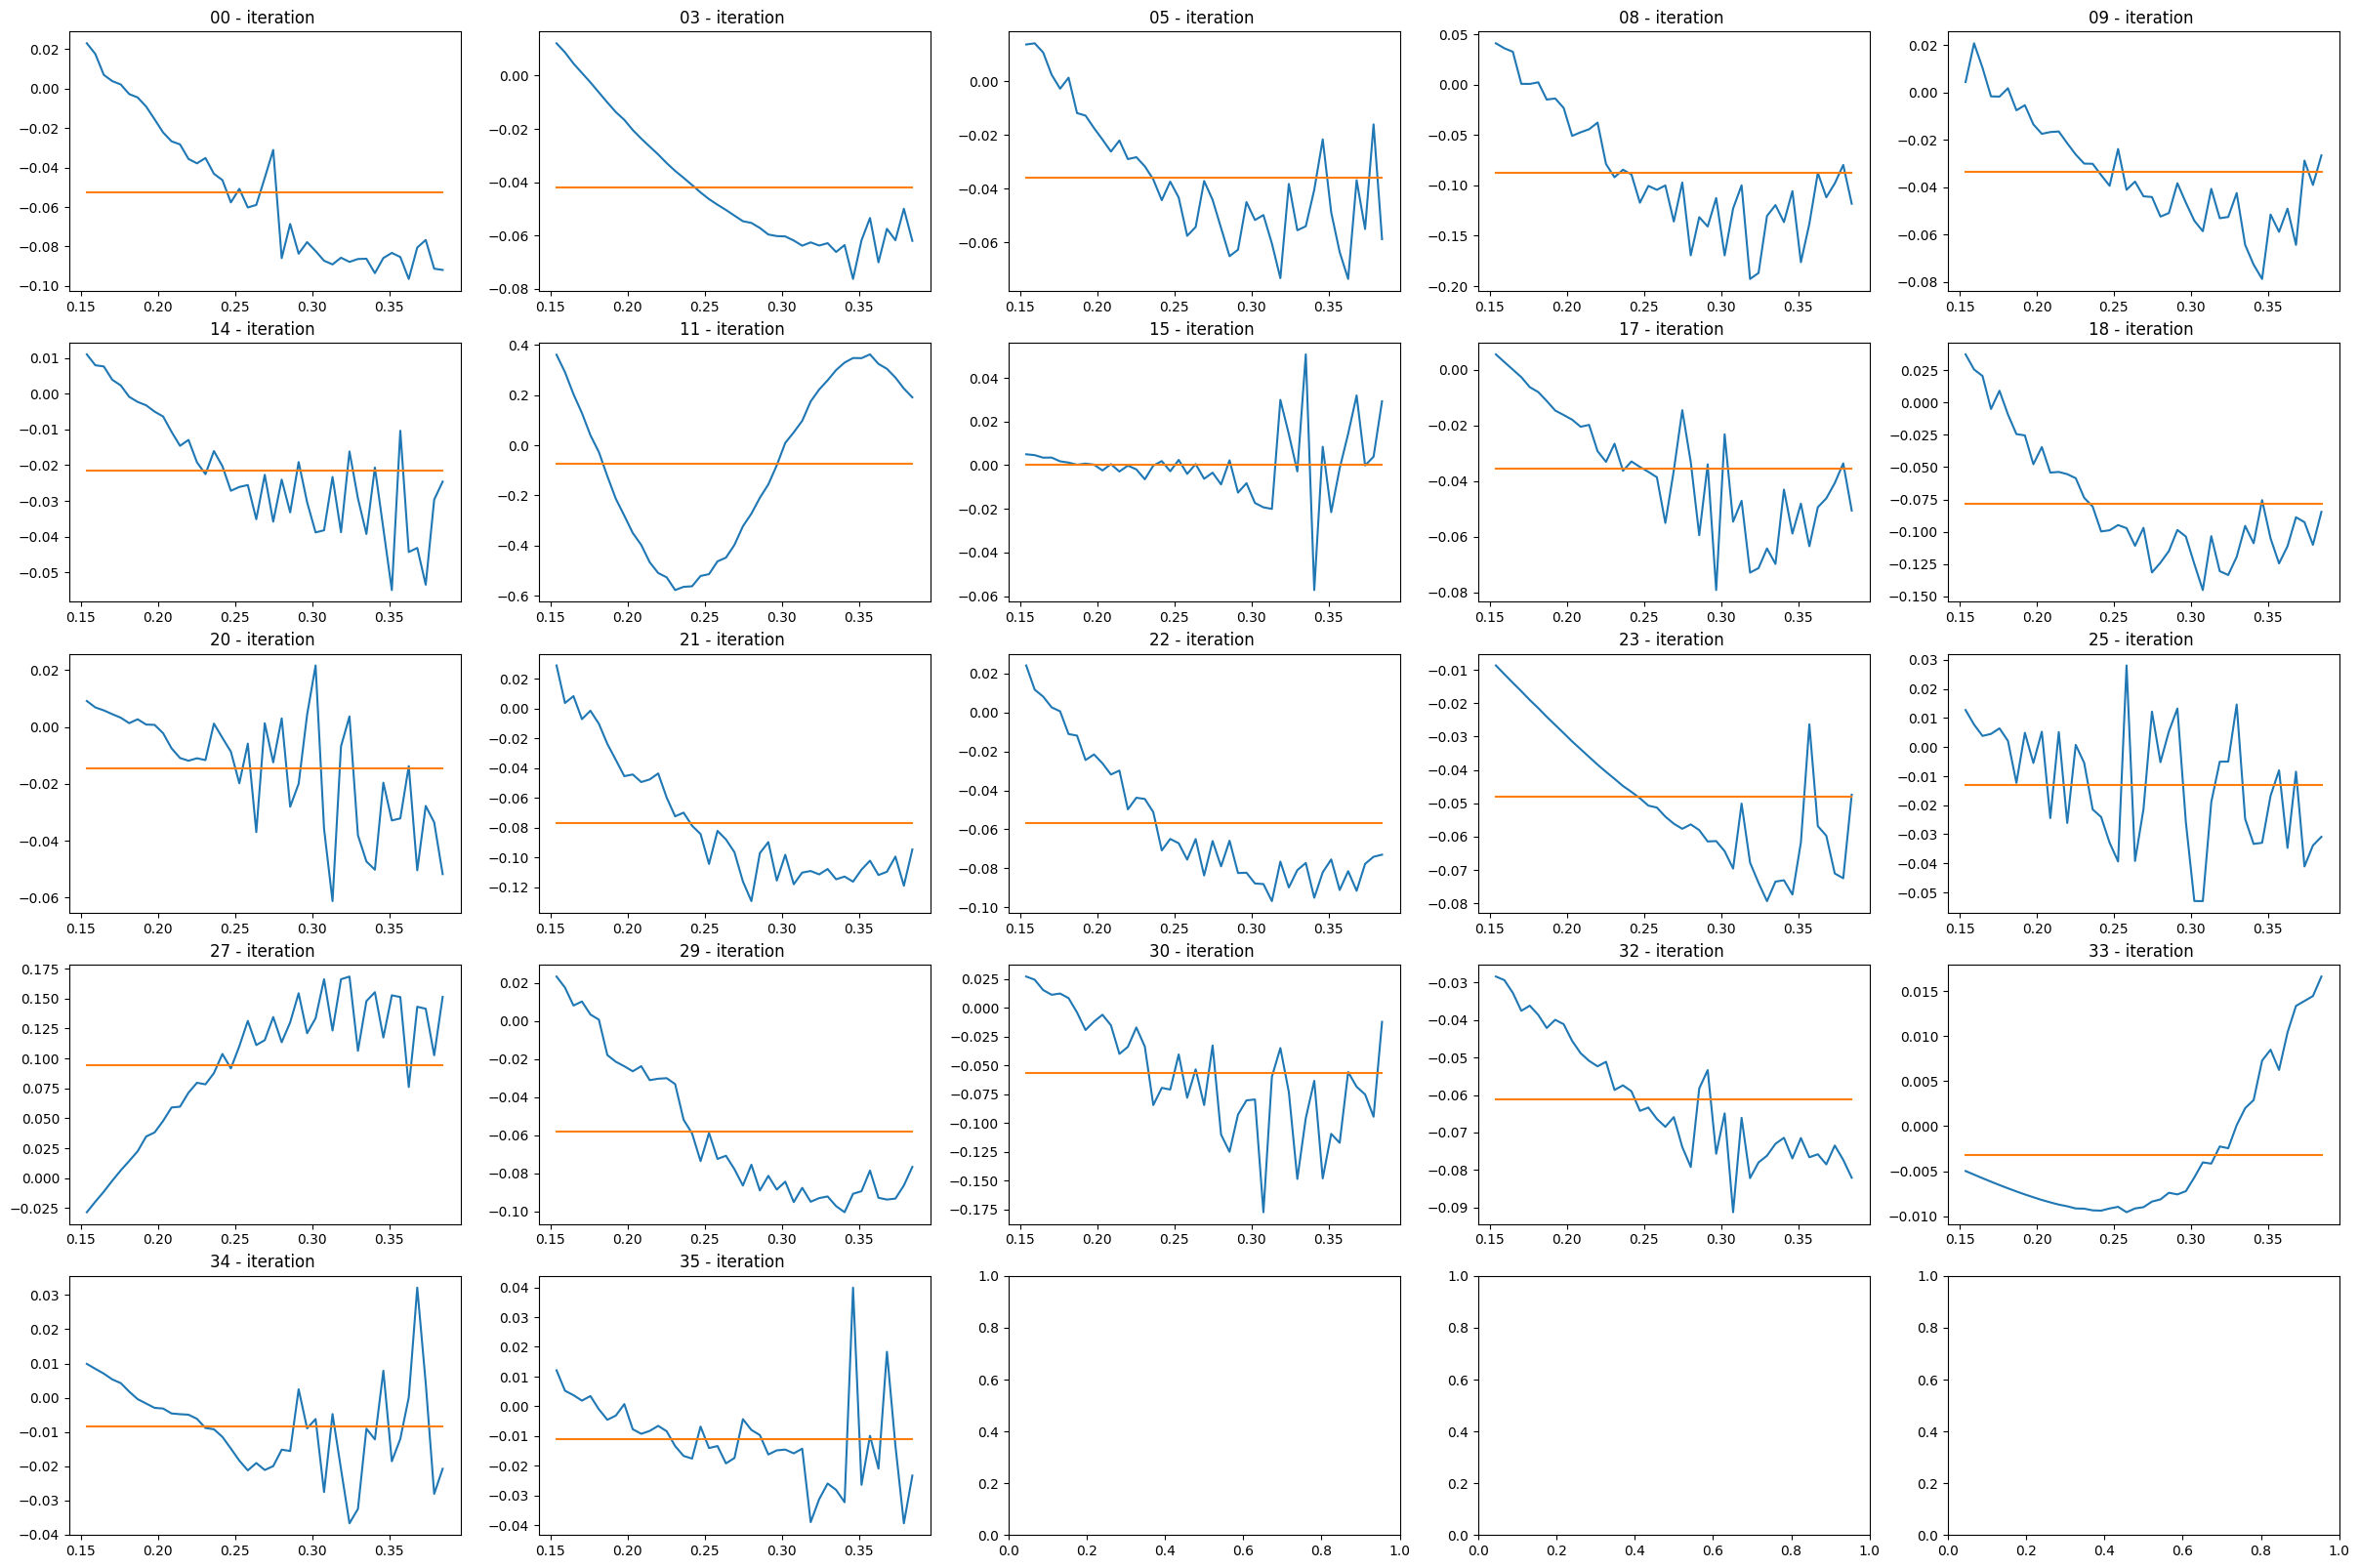

In [57]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 5, ncols = 5)
furier_peaks = []

for counter, k in enumerate(nice_indexes_2):

    times = lpf(pure_arithmetic[k])
    times -= times[0]

    #furiet transform
    N = times.shape[0]
    fft_y = rfft(times.to_numpy())
    fft_x = rfftfreq(N, 1 / 500) # 500 goes for Sample Rate

    data_fram = pd.DataFrame(columns=['Ampltude', 'Frequency'], data = np.array([fft_y, fft_x]).T)

    if counter < 25:
        ax[counter // 5][(counter) % 5].plot(data_fram['Frequency'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39], data_fram['Ampltude'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39])
        ax[counter // 5][(counter) % 5].plot(data_fram['Frequency'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39], np.ones(data_fram['Frequency'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39].shape[0]) * data_fram['Ampltude'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39].mean())
        #ax[counter // 5][(counter) % 5].plot(data_fram['Frequency'][data_fram['Frequency'] < 50], data_fram['Ampltude'][data_fram['Frequency'] < 50])
        #ax[counter // 5][(counter) % 5].plot(data_fram['Frequency'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39], np.ones(data_fram['Frequency'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39].shape[0]) * data_fram['Ampltude'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39].mean())
        ax[counter // 5][(counter) % 5].set_title(nice_indexes_2[counter] + ' - iteration ')
        
        ax[counter // 5][(counter) % 5].set_title(nice_indexes_2[counter] + ' - iteration ')
        
    
    furier_peaks = np.append(furier_peaks, data_fram['Ampltude'][data_fram['Frequency'] > 0.15][data_fram['Frequency'] < 0.39].max())


#### Fast-Fourier Transform
### Furiet peaks, HF: 0,04–0,15 Hz

c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values t

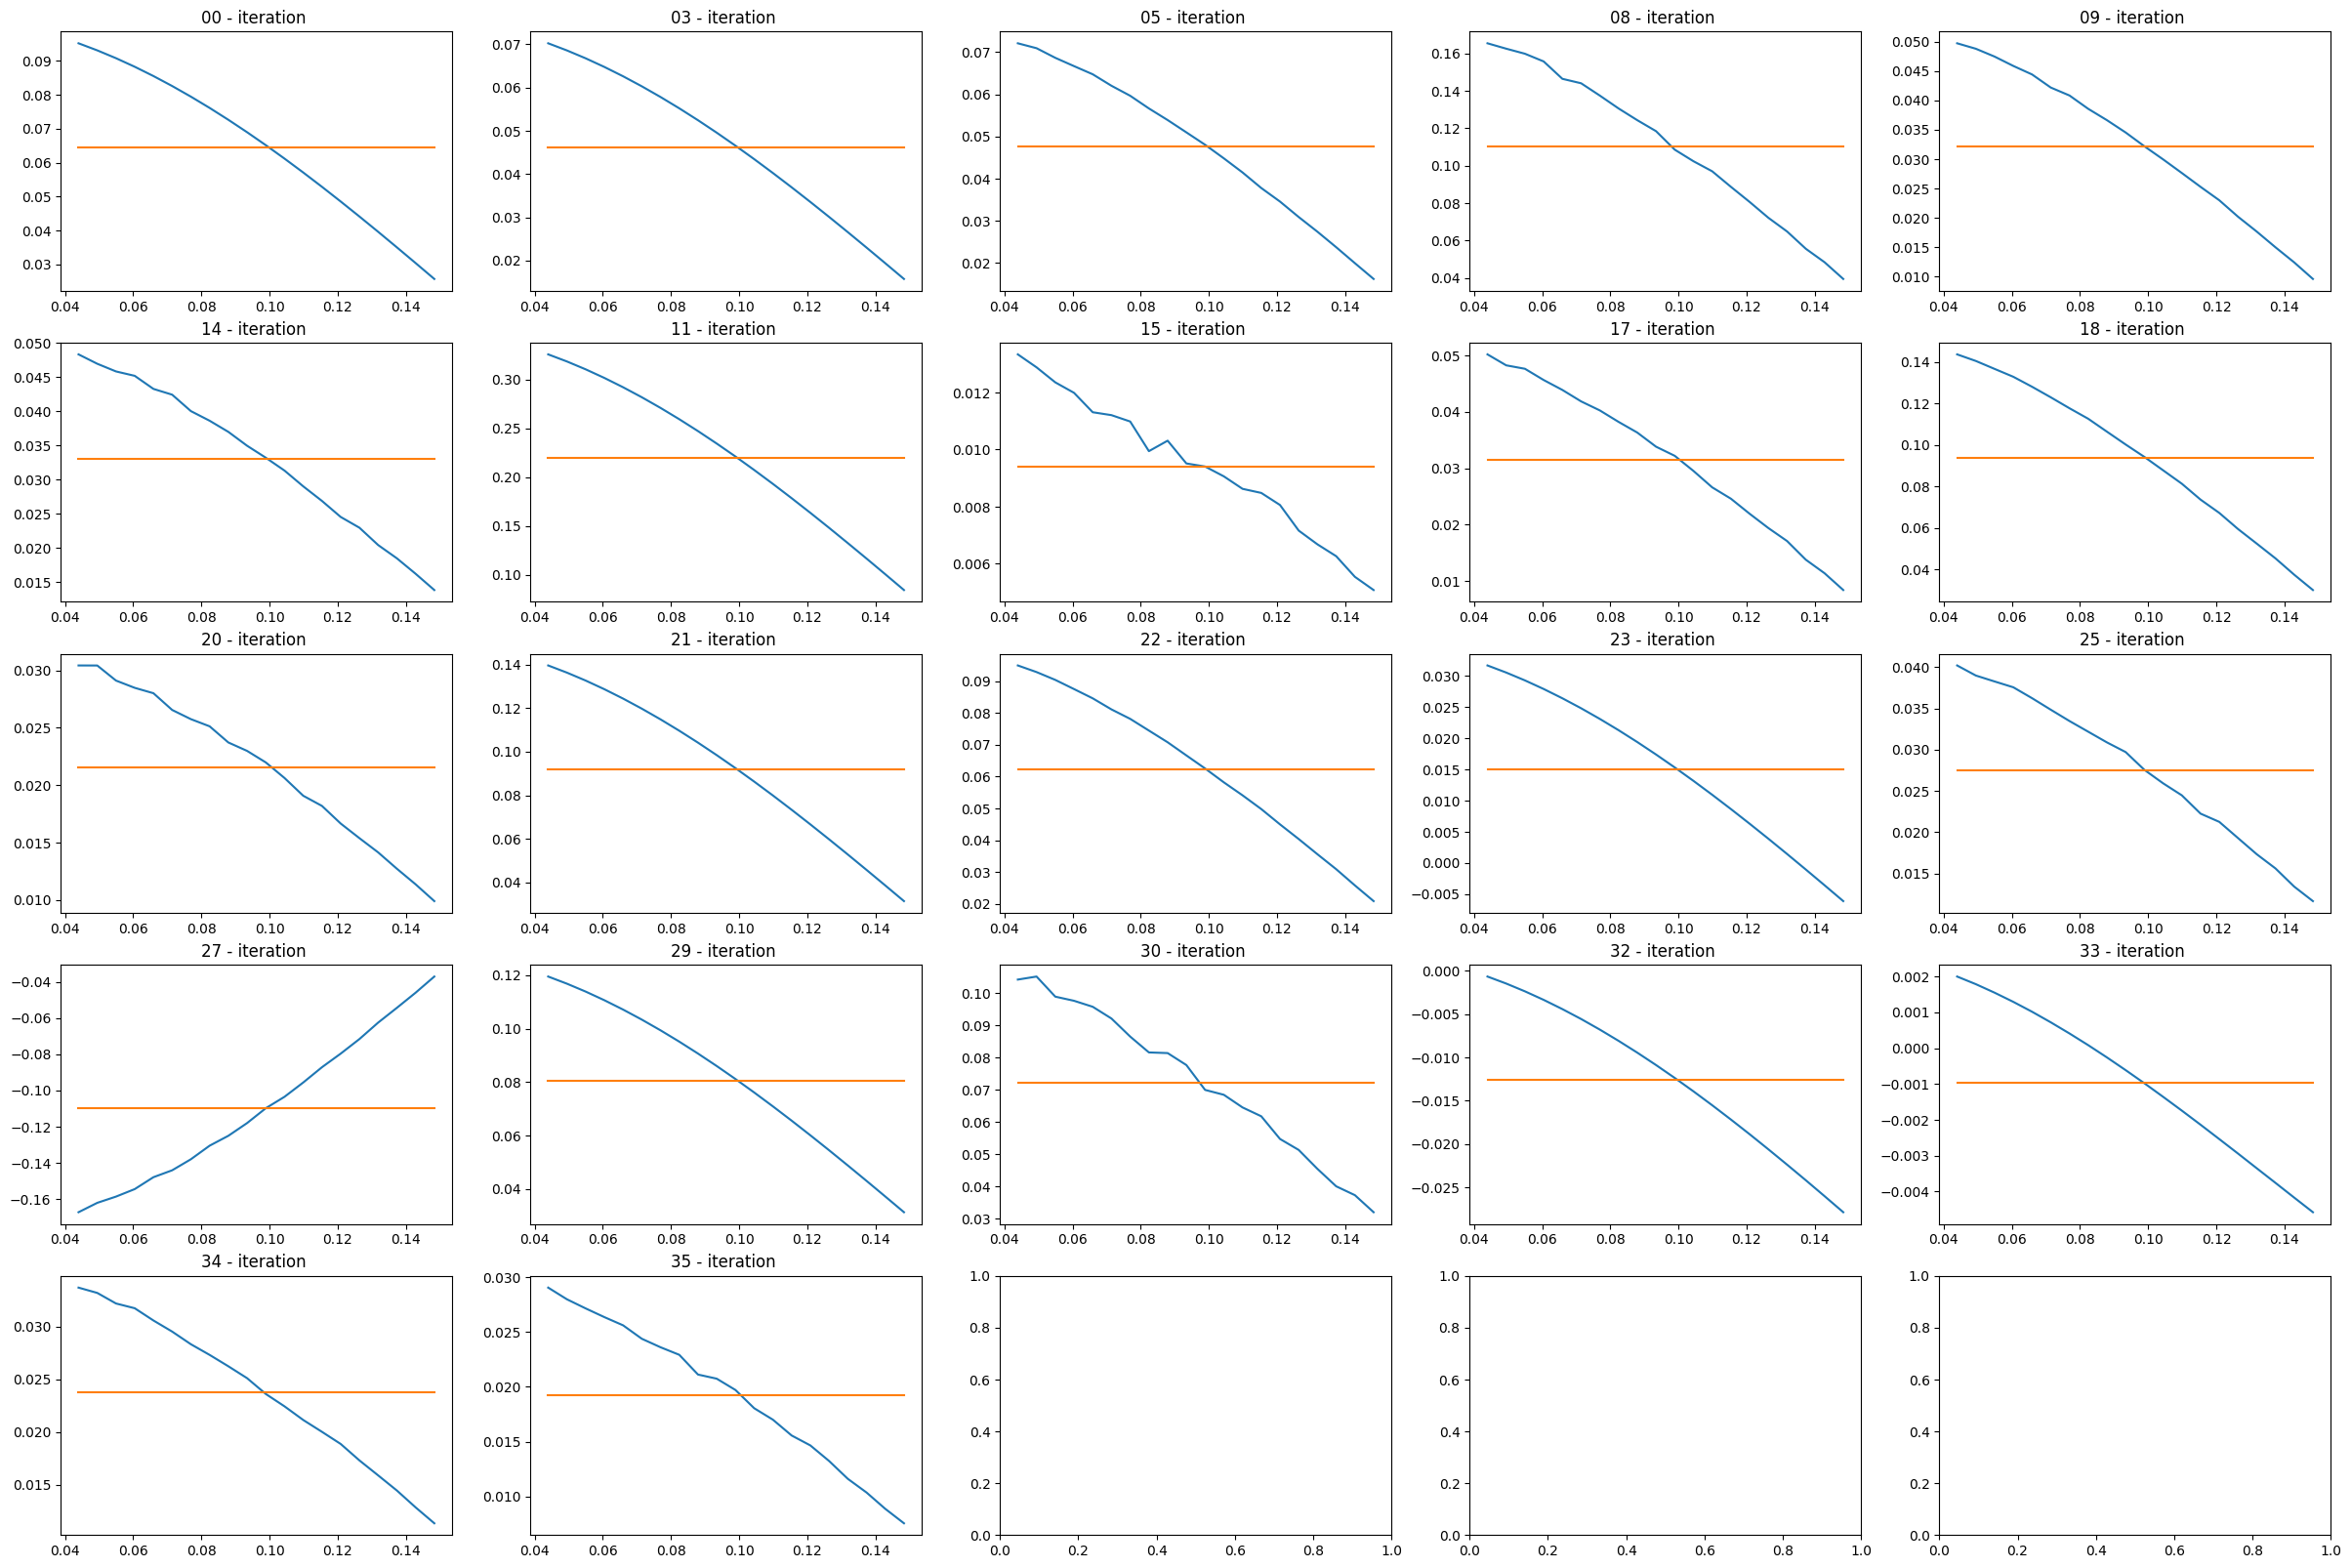

In [105]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 5, ncols = 5)

for counter, k in enumerate(nice_indexes_2):

    times = lpf(pure_arithmetic[k], param = 0.15)
    times -= times[0]

    #furiet transform
    N = times.shape[0]
    fft_y = rfft(times.to_numpy())
    fft_x = rfftfreq(N, 1 / 500) # 500 goes for Sample Rate

    data_fram = pd.DataFrame(columns=['Ampltude', 'Frequency'], data = np.array([fft_y, fft_x]).T)

    if counter < 25:
        ax[counter // 5][(counter) % 5].plot(data_fram['Frequency'][data_fram['Frequency'] < 0.15][data_fram['Frequency'] > 0.04], data_fram['Ampltude'][data_fram['Frequency'] < 0.15][data_fram['Frequency'] > 0.04])
        ax[counter // 5][(counter) % 5].plot(data_fram['Frequency'][data_fram['Frequency'] < 0.15][data_fram['Frequency'] > 0.04], np.ones(data_fram['Frequency'][data_fram['Frequency'] < 0.15][data_fram['Frequency'] > 0.04].shape[0]) * data_fram['Ampltude'][data_fram['Frequency'] < 0.15][data_fram['Frequency'] > 0.04].mean())
        ax[counter // 5][(counter) % 5].set_title(nice_indexes_2[counter] + ' - iteration ')

In [69]:
hf_array    = np.array([])
lf_array    = np.array([])
lf_hf_array = np.array([])

In [72]:
for i in indexes:
    wd, m = heartpy.process(pure_arithmetic[i], sample_rate=500, freq_method='fft', calc_freq = True)
    hf_array = np.append(hf_array, m['hf'])
    lf_array = np.append(lf_array, m['lf'])
    lf_hf_array = np.append(lf_hf_array, m['lf/hf'])
None

c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\heartpy\peakdetection.py:194: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_values = peaksy[peakedges[i]:peakedges[i+1]].tolist()
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\heartpy\peakdetection.py:194: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_values = peaksy[peakedges[i]:peakedges[i+1]].tolist()
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\h

(array([18., 18.,  6.,  6.,  6.,  2.,  2.,  4.,  0.,  2.]),
 array([0.        , 0.32842816, 0.65685632, 0.98528449, 1.31371265,
        1.64214081, 1.97056897, 2.29899713, 2.62742529, 2.95585346,
        3.28428162]),
 <BarContainer object of 10 artists>)

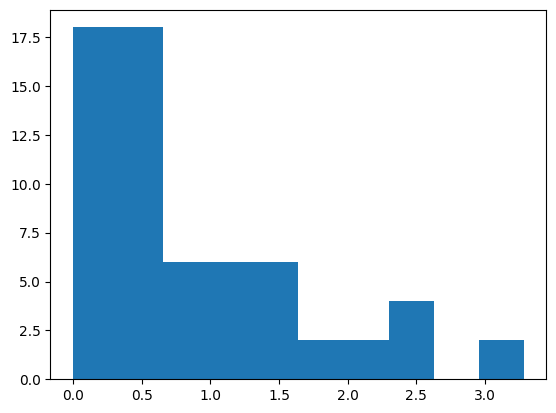

In [80]:
plt.hist(lf_hf_array, bins = 10)

### The MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database

In [82]:
data          = pd.read_csv('archive/mitbih_train.csv')
data_test     = pd.read_csv('archive/mitbih_test.csv')
data_normal   = pd.read_csv('archive/ptbdb_normal.csv')
data_abnormal = pd.read_csv('archive/ptbdb_abnormal.csv')

In [83]:
data.head(10)

9.779411554336547852e-01  9.264705777168273926e-01  \
0                  0.960114                  0.863248   
1                  1.000000                  0.659459   
2                  0.925414                  0.665746   
3                  0.967136                  1.000000   
4                  0.927461                  1.000000   
5                  0.423611                  0.791667   
6                  0.716814                  0.539823   
7                  0.874214                  0.849057   
8                  1.000000                  0.996086   
9                  0.985507                  0.880435   

   6.813725233078002930e-01  2.450980395078659058e-01  \
0                  0.461538                  0.196581   
1                  0.186486                  0.070270   
2                  0.541436                  0.276243   
3                  0.830986                  0.586854   
4                  0.626943                  0.193437   
5                  1.000000                  0.256944   
6                  0.283186                  0.129794   
7                  0.480084                  0.058700   
8                  0.694716                  0.336595   
9                  0.518116                  0.213768   

   1.544117629528045654e-01  1.911764740943908691e-01  \
0                  0.094017                  0.125356   
1                  0.070270                  0.059459   
2                  0.196133                  0.077348   
3                  0.356808                  0.248826   
4                  0.094991                  0.072539   
5                  0.000000                  0.277778   
6                  0.064897                  0.076696   
7                  0.090147                  0.310273   
8                  0.238748                  0.268102   
9                  0.126812                  0.119565   

   1.519607901573181152e-01  8.578431606292724609e-02  \
0                  0.099715                  0.088319   
1                  0.056757                  0.043243   
2                  0.071823                  0.060773   
3                  0.145540                  0.089202   
4                  0.043178                  0.053541   
5                  0.465278                  0.520833   
6                  0.026549                  0.032448   
7                  0.387841                  0.385744   
8                  0.191781                  0.174168   
9                  0.083333                  0.079710   

   5.882352963089942932e-02  4.901960864663124084e-02  ...  \
0                  0.074074                  0.082621  ...   
1                  0.054054                  0.045946  ...   
2                  0.066298                  0.058011  ...   
3                  0.117371                  0.150235  ...   
4                  0.093264                  0.189983  ...   
5                  0.472222                  0.555556  ...   
6                  0.008850                  0.044248  ...   
7                  0.389937                  0.392034  ...   
8                  0.164384                  0.187867  ...   
9                  0.065217                  0.068841  ...   

   0.000000000000000000e+00.79  0.000000000000000000e+00.80  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   
5                          0.0                          0.0   
6                          0.0                          0.0   
7                          0.0                          0.0   
8                          0.0                          0.0   
9                          0.0                          0.0   

   0.000000000000000000e+00.81  0.000000000000000000e+00.82  \
0                          0.0                     

In [84]:
data_test.head(10)

1.000000000000000000e+00  7.582644820213317871e-01  \
0                  0.908425                  0.783883   
1                  0.730088                  0.212389   
2                  1.000000                  0.910417   
3                  0.570470                  0.399329   
4                  1.000000                  0.923664   
5                  1.000000                  0.797260   
6                  0.909408                  0.975610   
7                  0.927803                  0.866359   
8                  1.000000                  0.914230   
9                  0.997429                  0.861183   

   1.115702465176582336e-01  0.000000000000000000e+00  \
0                  0.531136                  0.362637   
1                  0.000000                  0.119469   
2                  0.681250                  0.472917   
3                  0.238255                  0.147651   
4                  0.656489                  0.195929   
5                  0.320548                  0.043836   
6                  0.533101                  0.134146   
7                  0.299539                  0.000000   
8                  0.473684                  0.000000   
9                  0.365039                  0.071979   

   8.057851344347000122e-02  7.851240038871765137e-02  \
0                  0.366300                  0.344322   
1                  0.101770                  0.101770   
2                  0.229167                  0.068750   
3                  0.000000                  0.003356   
4                  0.111959                  0.175573   
5                  0.049315                  0.065753   
6                  0.066202                  0.000000   
7                  0.231951                  0.317972   
8                  0.064327                  0.317739   
9                  0.082262                  0.100257   

   6.611569970846176147e-02  4.958677664399147034e-02  \
0                  0.333333                  0.307692   
1                  0.110619                  0.123894   
2                  0.000000                  0.004167   
3                  0.040268                  0.080537   
4                  0.122137                  0.050891   
5                  0.030137                  0.008219   
6                  0.010453                  0.012195   
7                  0.274962                  0.262673   
8                  0.405458                  0.391813   
9                  0.074550                  0.051414   

   4.752065986394882202e-02  3.512396663427352905e-02  ...  \
0                  0.296703                  0.300366  ...   
1                  0.115044                  0.132743  ...   
2                  0.014583                  0.054167  ...   
3                  0.070470                  0.090604  ...   
4                  0.035623                  0.055980  ...   
5                  0.005479                  0.010959  ...   
6                  0.031359                  0.146341  ...   
7                  0.270353                  0.268817  ...   
8                  0.382066                  0.401559  ...   
9                  0.051414                  0.043702  ...   

   0.000000000000000000e+00.56  0.000000000000000000e+00.57  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   
5                          0.0                          0.0   
6                          0.0                          0.0   
7                          0.0                          0.0   
8                          0.0                          0.0   
9                          0.0                          0.0   

   0.000000000000000000e+00.58  0.000000000000000000e+00.59  \
0                          0.0                     

In [85]:
data_normal.head()

1.000000000000000000e+00  9.003241658210754395e-01  \
0                  1.000000                  0.794681   
1                  0.909029                  0.791482   
2                  1.000000                  0.478893   
3                  1.000000                  0.867238   
4                  0.948983                  0.505265   

   3.585899472236633301e-01  5.145867168903350830e-02  \
0                  0.375387                  0.116883   
1                  0.423169                  0.186712   
2                  0.056760                  0.064176   
3                  0.201360                  0.099349   
4                  0.004176                  0.022513   

   4.659643396735191345e-02  1.268233358860015869e-01  \
0                  0.000000                  0.171923   
1                  0.000000                  0.007836   
2                  0.081289                  0.072732   
3                  0.141336                  0.120934   
4                  0.059550                  0.107298   

   1.333063244819641113e-01  1.191247999668121338e-01  \
0                  0.283859                  0.293754   
1                  0.063032                  0.077002   
2                  0.055619                  0.048774   
3                  0.108516                  0.096393   
4                  0.110385                  0.111293   

   1.106158867478370667e-01  1.130470037460327148e-01  ...  \
0                  0.325912                  0.345083  ...   
1                  0.074957                  0.077342  ...   
2                  0.054478                  0.041643  ...   
3                  0.093436                  0.100828  ...   
4                  0.116558                  0.118192  ...   

   0.000000000000000000e+00.56  0.000000000000000000e+00.57  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   0.000000000000000000e+00.58  0.000000000000000000e+00.59  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   0.000000000000000000e+00.60  0.000000000000000000e+00.61  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   0.000000000000000000e+00.62  0.000000000000000000e+00.63  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   0.000000000000000000e+00.64  0.000000000000000000e+00.65  
0                          0.0                          0.0  
1                          0.0                          0.0  
2                          0.0                          0.0  
3                          0.0                          0.0  
4                          0.0                          0.0  

[5 rows x 188 columns]

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87553 entries, 0 to 87552
Columns: 188 entries, 9.779411554336547852e-01 to 0.000000000000000000e+00.88
dtypes: float64(188)
memory usage: 125.6 MB


In [87]:
time_ = data.columns

In [88]:
print(time_)

Index(['9.779411554336547852e-01', '9.264705777168273926e-01',
       '6.813725233078002930e-01', '2.450980395078659058e-01',
       '1.544117629528045654e-01', '1.911764740943908691e-01',
       '1.519607901573181152e-01', '8.578431606292724609e-02',
       '5.882352963089942932e-02', '4.901960864663124084e-02',
       ...
       '0.000000000000000000e+00.79', '0.000000000000000000e+00.80',
       '0.000000000000000000e+00.81', '0.000000000000000000e+00.82',
       '0.000000000000000000e+00.83', '0.000000000000000000e+00.84',
       '0.000000000000000000e+00.85', '0.000000000000000000e+00.86',
       '0.000000000000000000e+00.87', '0.000000000000000000e+00.88'],
      dtype='object', length=188)


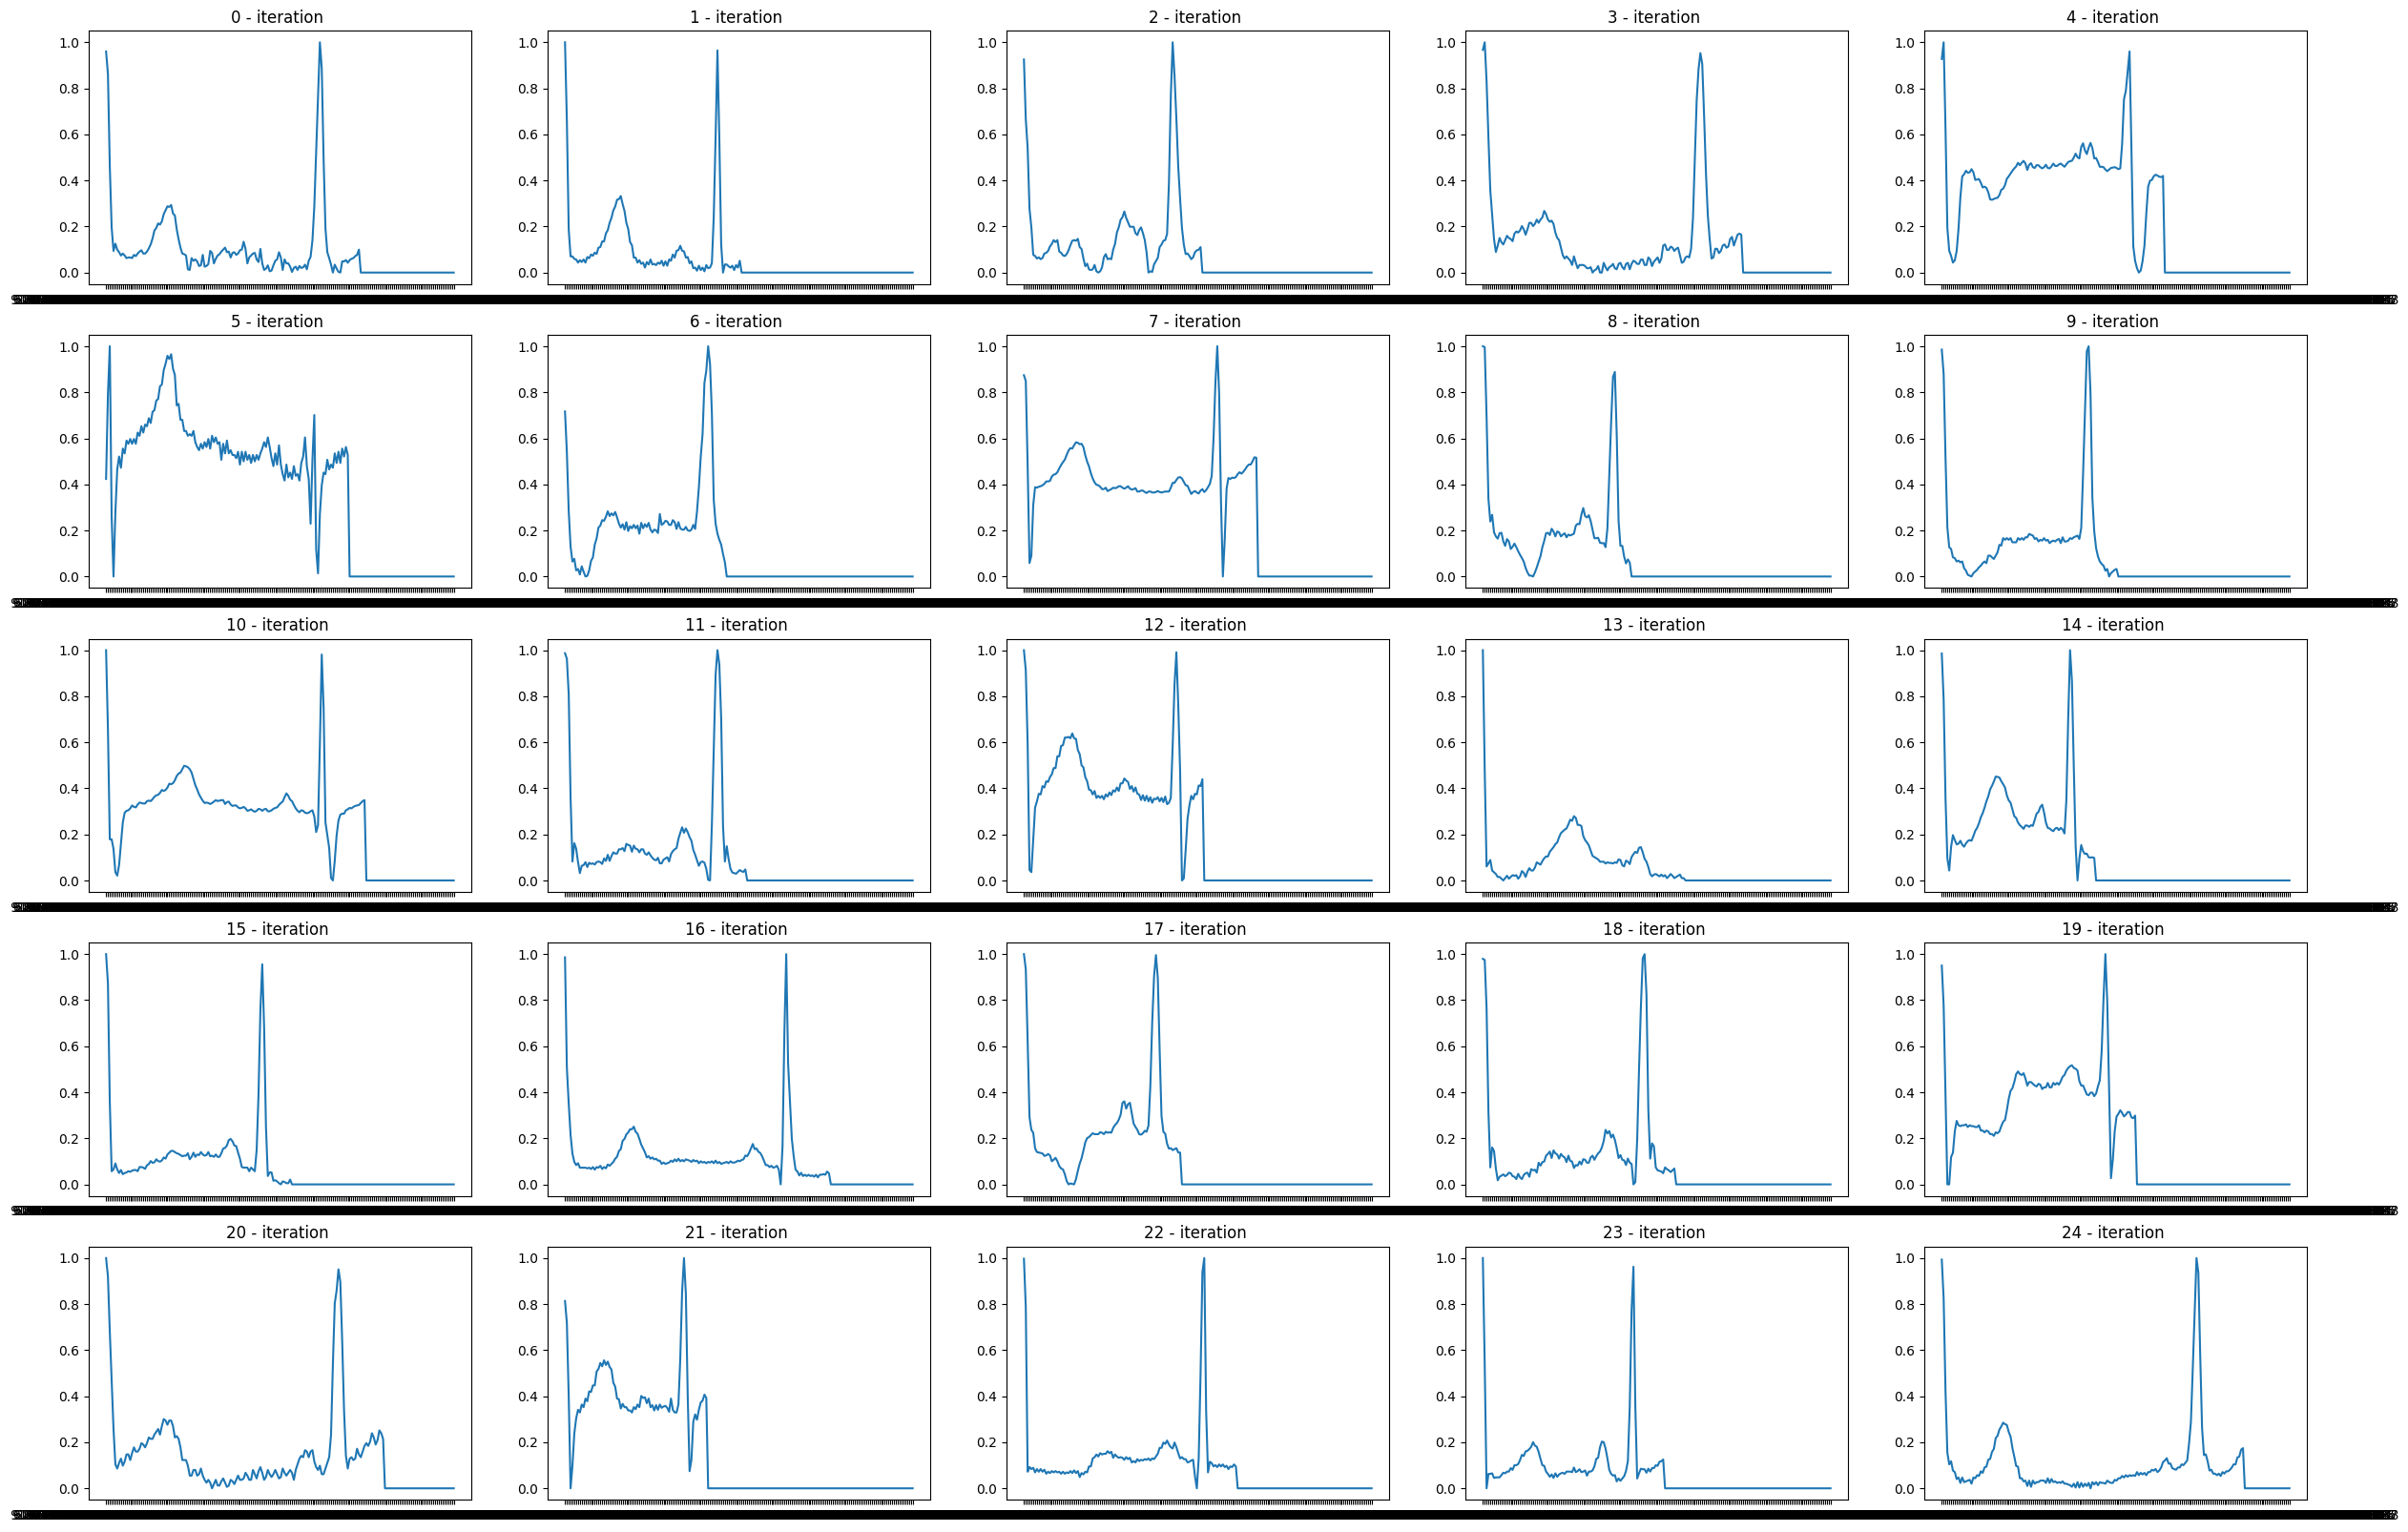

In [89]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 5, ncols = 5)

for i in range(25):
    ax[i // 5][i % 5].plot(time_, data[i:i+1].to_numpy()[0])
    ax[i // 5][i % 5].set_title(str(i) + ' - iteration ')

plt.show()

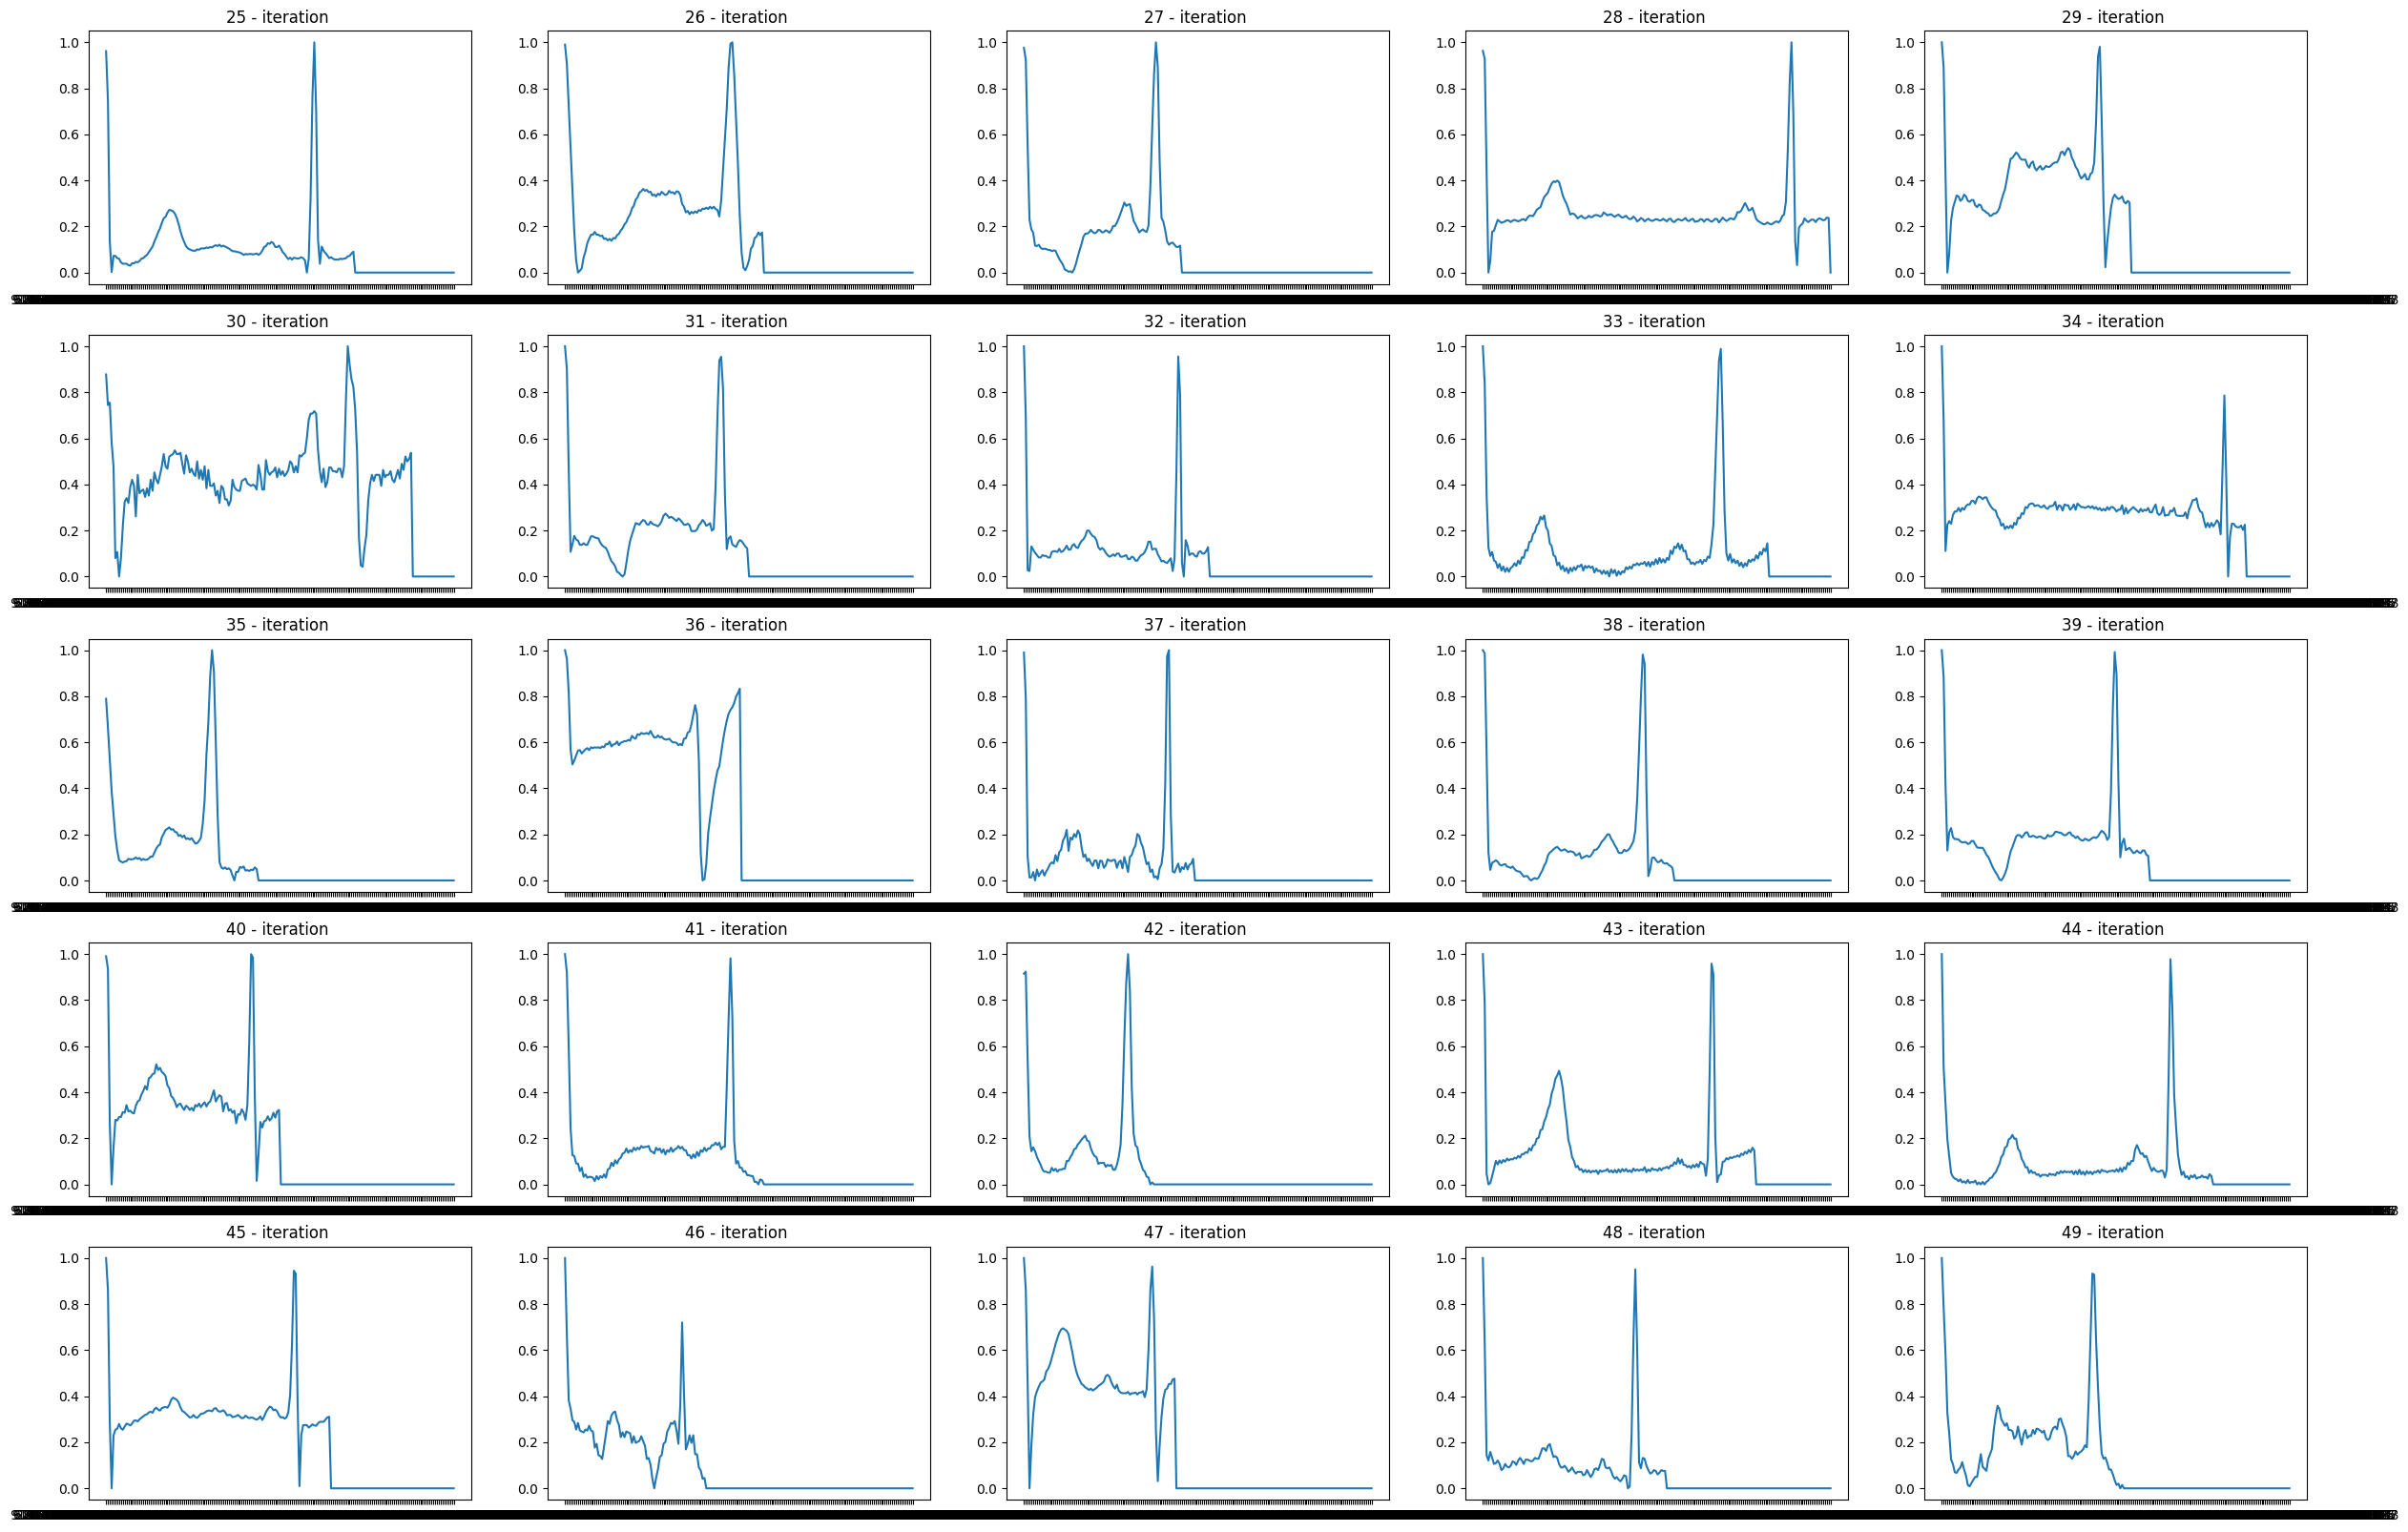

In [90]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 5, ncols = 5)

for i in range(25, 50):
    ax[(i - 25 ) // 5][(i - 25 ) % 5].plot(time_, data[i:i+1].to_numpy()[0])
    ax[(i - 25 ) // 5][(i - 25 ) % 5].set_title(str(i) + ' - iteration ')

In [91]:
times_of_peaks = np.array([])

In [92]:
for i in range(data.shape[0]):
    times_of_peaks = np.append(times_of_peaks, [data[i:i+1].to_numpy()[0][5:].argmax()])

In [93]:
for i in range(data_test.shape[0]):
    times_of_peaks = np.append(times_of_peaks, [data_test[i:i+1].to_numpy()[0][5:].argmax()])

In [94]:
for i in range(data_normal.shape[0]):
    times_of_peaks = np.append(times_of_peaks, [data_normal[i:i+1].to_numpy()[0][5:].argmax()])

In [95]:
for i in range(data_abnormal.shape[0]):
    times_of_peaks = np.append(times_of_peaks, [data_abnormal[i:i+1].to_numpy()[0][5:].argmax()])

In [96]:
times_of_peaks.shape[0] == data.shape[0] + data_test.shape[0] + data_normal.shape[0] + data_abnormal.shape[0]

True

In [97]:
times_of_peaks = times_of_peaks / 125


In [98]:
times_of_peaks = times_of_peaks[times_of_peaks < 1.4]

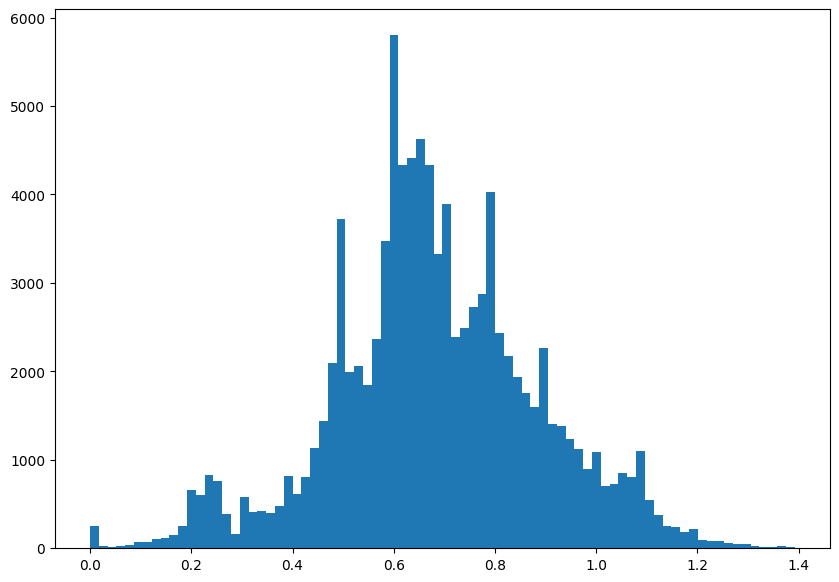

In [102]:
plt.figure(figsize = (10, 7))
plt.hist(times_of_peaks, bins = 80)
plt.show()

In [111]:
NN = np.append(times_of_peaks, real_times).copy()

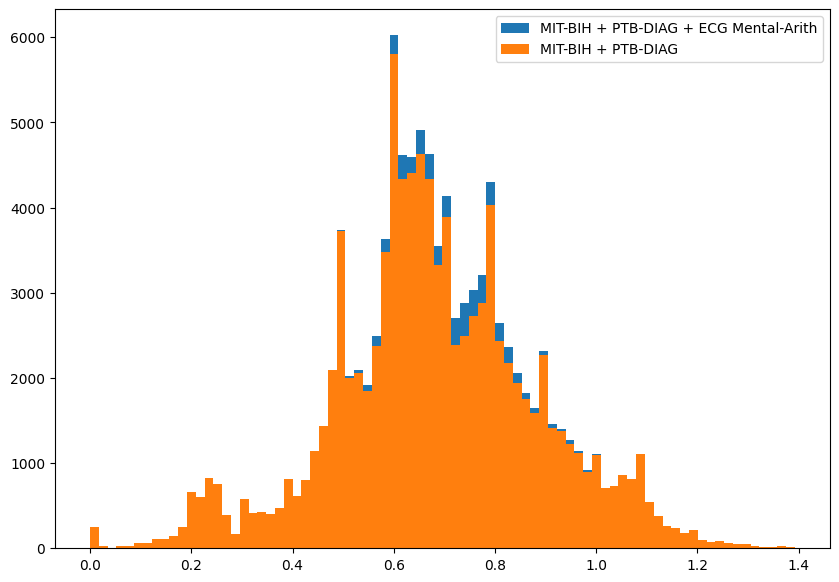

In [112]:
plt.figure(figsize = (10, 7))
plt.hist(NN, bins = 80, label = 'MIT-BIH + PTB-DIAG + ECG Mental-Arith')
plt.hist(times_of_peaks, bins = 80, label = 'MIT-BIH + PTB-DIAG')
plt.legend()
plt.show()

### Metrics Evaluation:

In [115]:
SDNN  = np.zeros(len(NN) // (180 * 5) - 1)
RMSSD = np.zeros(len(NN) // (180 * 5) - 1)
SDSD  = np.zeros(len(NN) // (180 * 5) - 1)

for i in range(len(NN) // (180 * 5) - 1):
    arr        = NN[180 * i: 180 * (i + 5) + 1]

    N = len(arr)
    average    = sum(arr) / N
    Dispersion = sum([(arr[i] - average) ** 2 for i in range(len(arr))]) / N
    sigma      = Dispersion ** 0.5

    #for SDNN
    SDNN[i]    = sigma
    
    #for RMSSD
    RMSSD[i] = sum([(arr[i] - arr[i + 1]) ** 2 for i in range(N - 1)])

    #for SDSD
    SDSD[i] = (sum([(arr[i] - arr[i + 1]) ** 2 for i in range(N - 1)]) / N) ** 0.5

#### SDNN for 5 minut intervals:

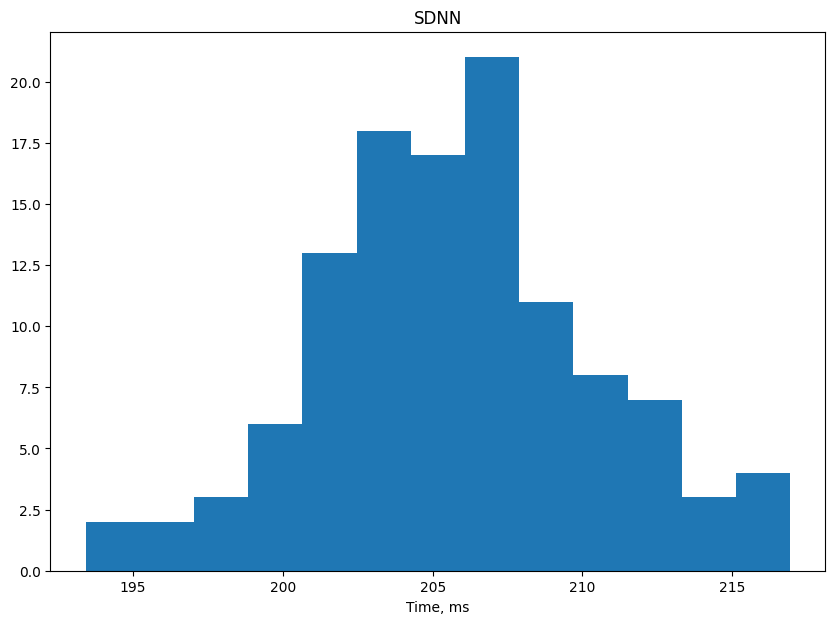

In [116]:
plt.figure(figsize = (10, 7))
plt.title('SDNN')
plt.hist(SDNN * 1000, bins = 13)
plt.xlabel('Time, ms')
plt.show()

#### RMSSD for 5 minut intervals:

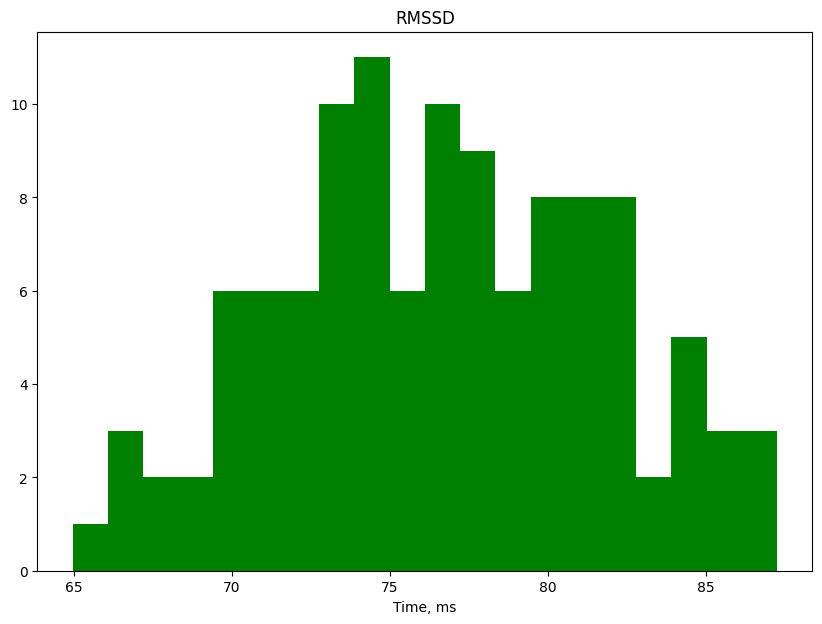

In [117]:
plt.figure(figsize = (10, 7))
plt.title('RMSSD')
plt.hist(RMSSD, bins = 20, color = 'Green')
plt.xlabel('Time, ms')
plt.show()

#### SDSD for 5 minut intervals:

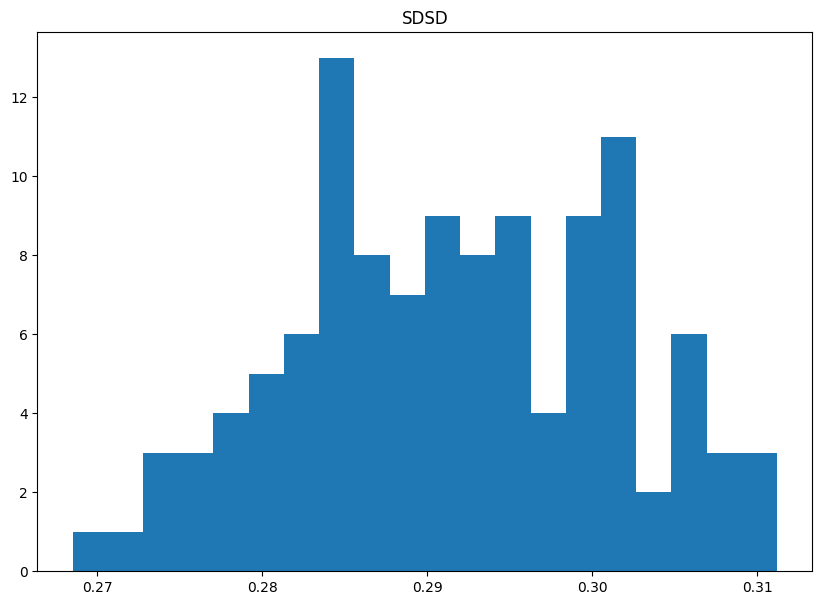

In [118]:
plt.figure(figsize = (10, 7))
plt.title('SDSD')
plt.hist(SDSD, bins = 20)
plt.show()

#### NN50:

In [119]:
NN50 = abs(NN[1:] - NN[:-1])
NN50 = NN50[NN50 <= 0.05]
print('NN50 quantity:   ', len(NN50))
print('NN50 ratio: \t ', round(len(NN50) / len(NN), 2))

NN50 quantity:    19704
NN50 ratio: 	  0.19


#### NN20:

In [120]:
NN20 = abs(NN[1:] - NN[:-1])
NN20 = NN20[NN20 <= 0.02]
print('NN20 quantity:   ', len(NN20))
print('NN20 ratio: \t ', round(len(NN20) / len(NN), 2))

NN20 quantity:    8488
NN20 ratio: 	  0.08


In [150]:
data_abnormal

9.322328567504882812e-01  8.696785569190979004e-01  \
0                      1.000000                  0.606941   
1                      1.000000                  0.951613   
2                      0.977819                  0.899261   
3                      0.935618                  0.801661   
4                      0.925265                  0.433352   
...                         ...                       ...   
10500                  0.981409                  1.000000   
10501                  0.906250                  0.922379   
10502                  1.000000                  0.867971   
10503                  1.000000                  0.984672   
10504                  0.997886                  0.700317   

       8.861859440803527832e-01  9.296264052391052246e-01  \
0                      0.384181                  0.254237   
1                      0.923963                  0.853303   
2                      0.230129                  0.032348   
3                      0.805815                  1.000000   
4                      0.073620                  0.079197   
...                         ...                       ...   
10500                  0.559171                  0.287093   
10501                  0.878024                  0.810484   
10502                  0.674122                  0.470332   
10503                  0.658888                  0.556394   
10504                  0.464059                  0.318182   

       9.087749719619750977e-01  9.339704513549804688e-01  \
0                      0.223567                  0.276836   
1                      0.791859                  0.734255   
2                      0.142329                  0.223660   
3                      0.722741                  0.480789   
4                      0.136643                  0.182934   
...                         ...                       ...   
10500                  0.196639                  0.204862   
10501                  0.712702                  0.667339   
10502                  0.296987                  0.169307   
10503                  0.446809                  0.395790   
10504                  0.233615                  0.184989   

       8.010425567626953125e-01  7.497828006744384766e-01  \
0                      0.253430                  0.184826   
1                      0.672043                  0.685100   
2                      0.328096                  0.367837   
3                      0.454829                  0.319834   
4                      0.182934                  0.182376   
...                         ...                       ...   
10500                  0.215946                  0.243833   
10501                  0.608871                  0.527218   
10502                  0.077664                  0.081392   
10503                  0.315260                  0.276367   
10504                  0.124207                  0.082981   

       6.872285008430480957e-01  6.350998878479003906e-01  ...  \
0                      0.153349                  0.121872  ...   
1                      0.670507                  0.667435  ...   
2                      0.381701                  0.389094  ...   
3                      0.266874                  0.308411  ...   
4                      0.196877                  0.203569  ...   
...                         ...                       ...  ...   
10500                  0.242760                  0.250268  ...   
10501                  0.480847                  0.442540  ...   
10502                  0.074868                  0.089779  ...   
10503                  0.261039                  0.258522  ...   
10504                  0.087738                  0.063953  ...   

       0.000000000000000000e+00.117  0.000000000000000000e+00.118  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3     

In [153]:
hf_array_normal  = np.array([])
hf_array_normal  = np.array([])
lf_hf_array_normal = np.array([])

In [154]:
for i in range(round(data_normal.shape[0] / 200)):
    data_to_find_ratio = data_normal.iloc[200 * i: 200 * (i + 1)].to_numpy().reshape(1, -1)[0]
    wd, m = heartpy.process(data_to_find_ratio, sample_rate=125, freq_method='fft', calc_freq = True)
    hf_array_normal = np.append(hf_array, m['hf'])
    lf_array_normal = np.append(lf_array, m['lf'])
    lf_hf_array_normal = np.append(lf_hf_array, m['lf/hf'])

In [155]:
for i in range(round(data_abnormal.shape[0] / 200)):
    data_to_find_ratio = data_abnormal.iloc[200 * i: 200 * (i + 1)].to_numpy().reshape(1, -1)[0]
    wd, m = heartpy.process(data_to_find_ratio, sample_rate=125, freq_method='fft', calc_freq = True)
    hf_array_normal = np.append(hf_array, m['hf'])
    lf_array_normal = np.append(lf_array, m['lf'])
    lf_hf_array_normal = np.append(lf_hf_array, m['lf/hf'])

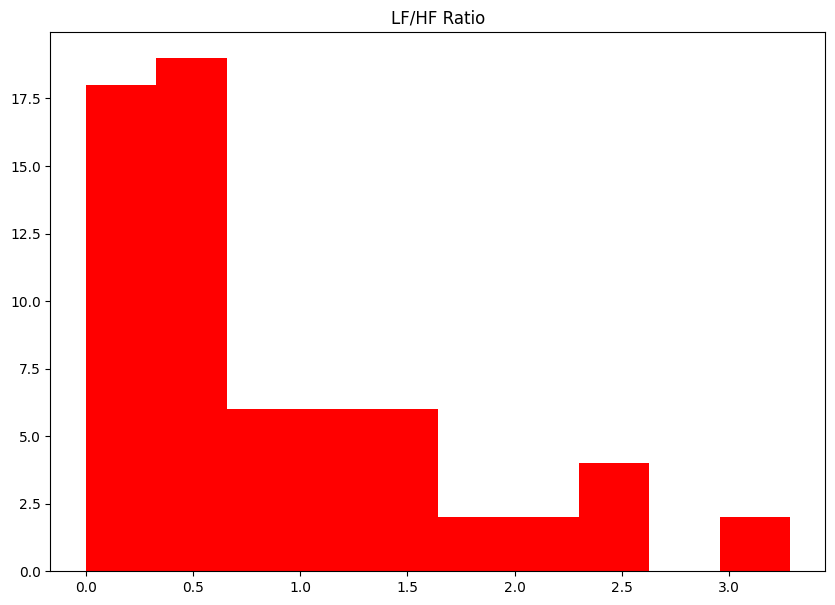

In [156]:
plt.figure(figsize = (10, 7))
plt.title('LF/HF Ratio')
plt.hist(lf_hf_array_normal, bins = 10, color = 'Red')
plt.show()

### Non-EEG Dataset for Assessment of Neurological Status

First  relax period - [0; 300] s

Second relax period - [600; 900] s

Third relax period - [1240; 1540] s

Fourth relax period - [1900; 2200] s


First sport period - [300; 600] s




Waiting - [1540; 1600]



First cognitive stress period - [900; 940] s

First emotional stress period - [940; 1240] s

Second emotional stress period - [1600; 1900] s




*Note: We had not originally intended to count the reading of the instructions to count backwards as an emotional stress. After all, instructions were given for each of the tasks. Unlike the other instruction sets, however, this one created a stress response in many of the volunteers that was obvious to the test administrator as the test was being given.*

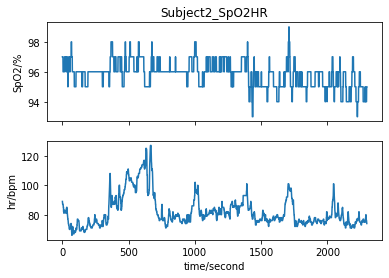

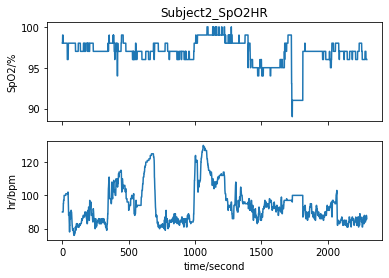

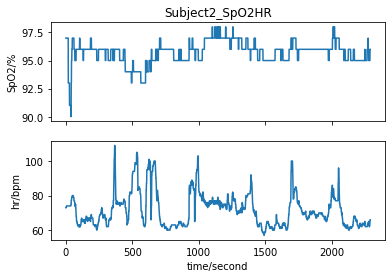

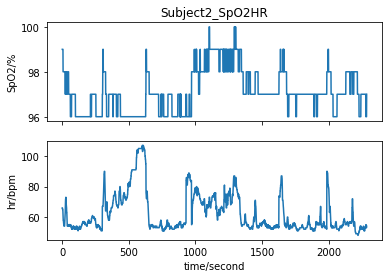

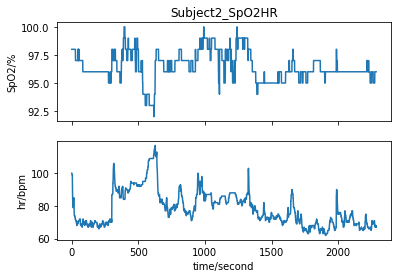

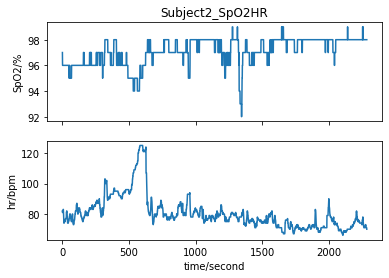

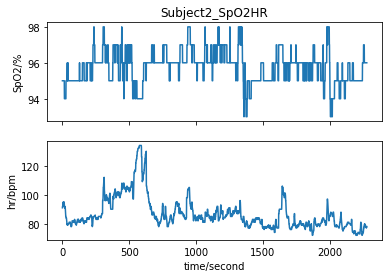

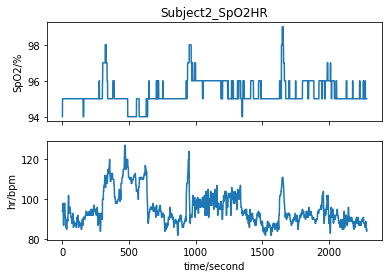

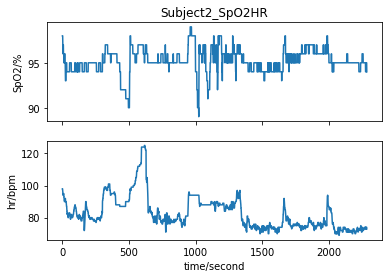

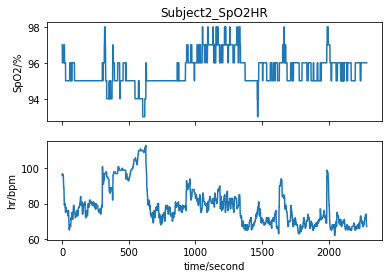

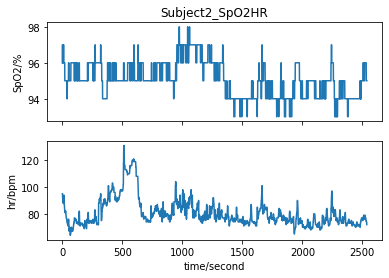

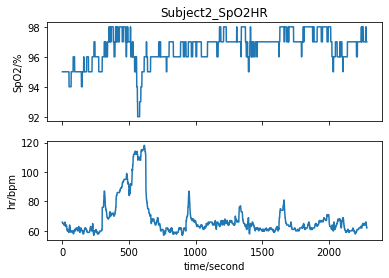

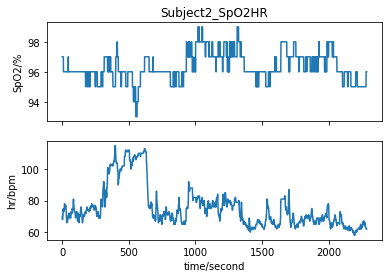

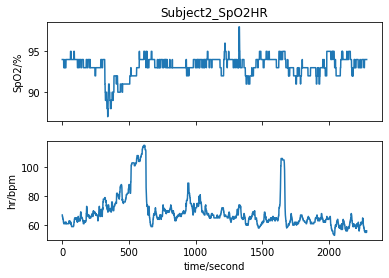

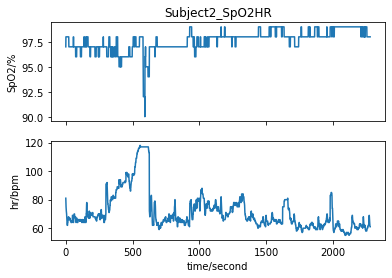

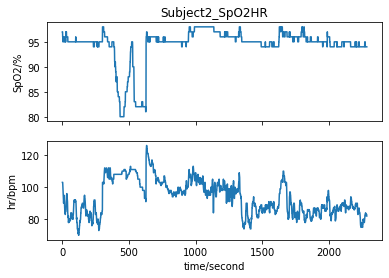

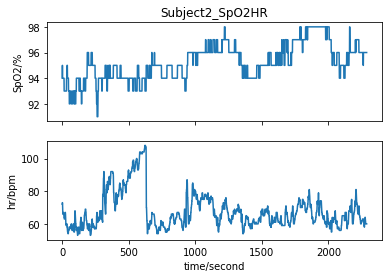

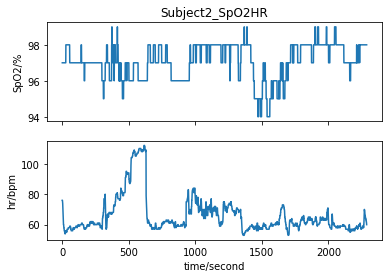

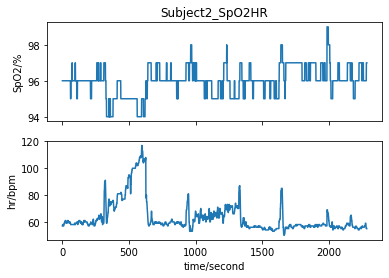

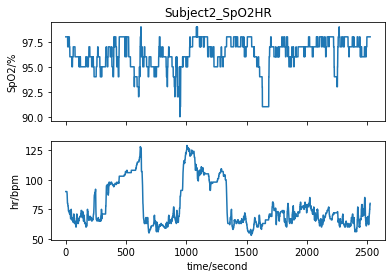

In [ ]:
indexes_neuro = [str(i) for i in range(1, 21)]
#columns_neuro = 'hr/bpm ' + np.array(indexes_neuro).astype(str)

neuro_data = pd.DataFrame(columns = indexes_neuro, data = np.zeros([2538, 20]))

for i in indexes_neuro:
    HR__ = wfdb.rdrecord('non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject{0}_SpO2HR'.format(i))
    wfdb.plot_wfdb(HR__, title = 'Subject2_SpO2HR') 

    data__ = pd.DataFrame(columns = ['Sp02HR', 'hr/bpm'], data = HR__ .__dict__['p_signal'])
    neuro_data[i] = np.append(data__['hr/bpm'].to_numpy(), np.zeros(2538 - data__.shape[0]))

#### First Relax vs First Physical period ECG

Physical heart rate approximately greater than relax in  1.3195253474896158 +- 0.011067101380208765


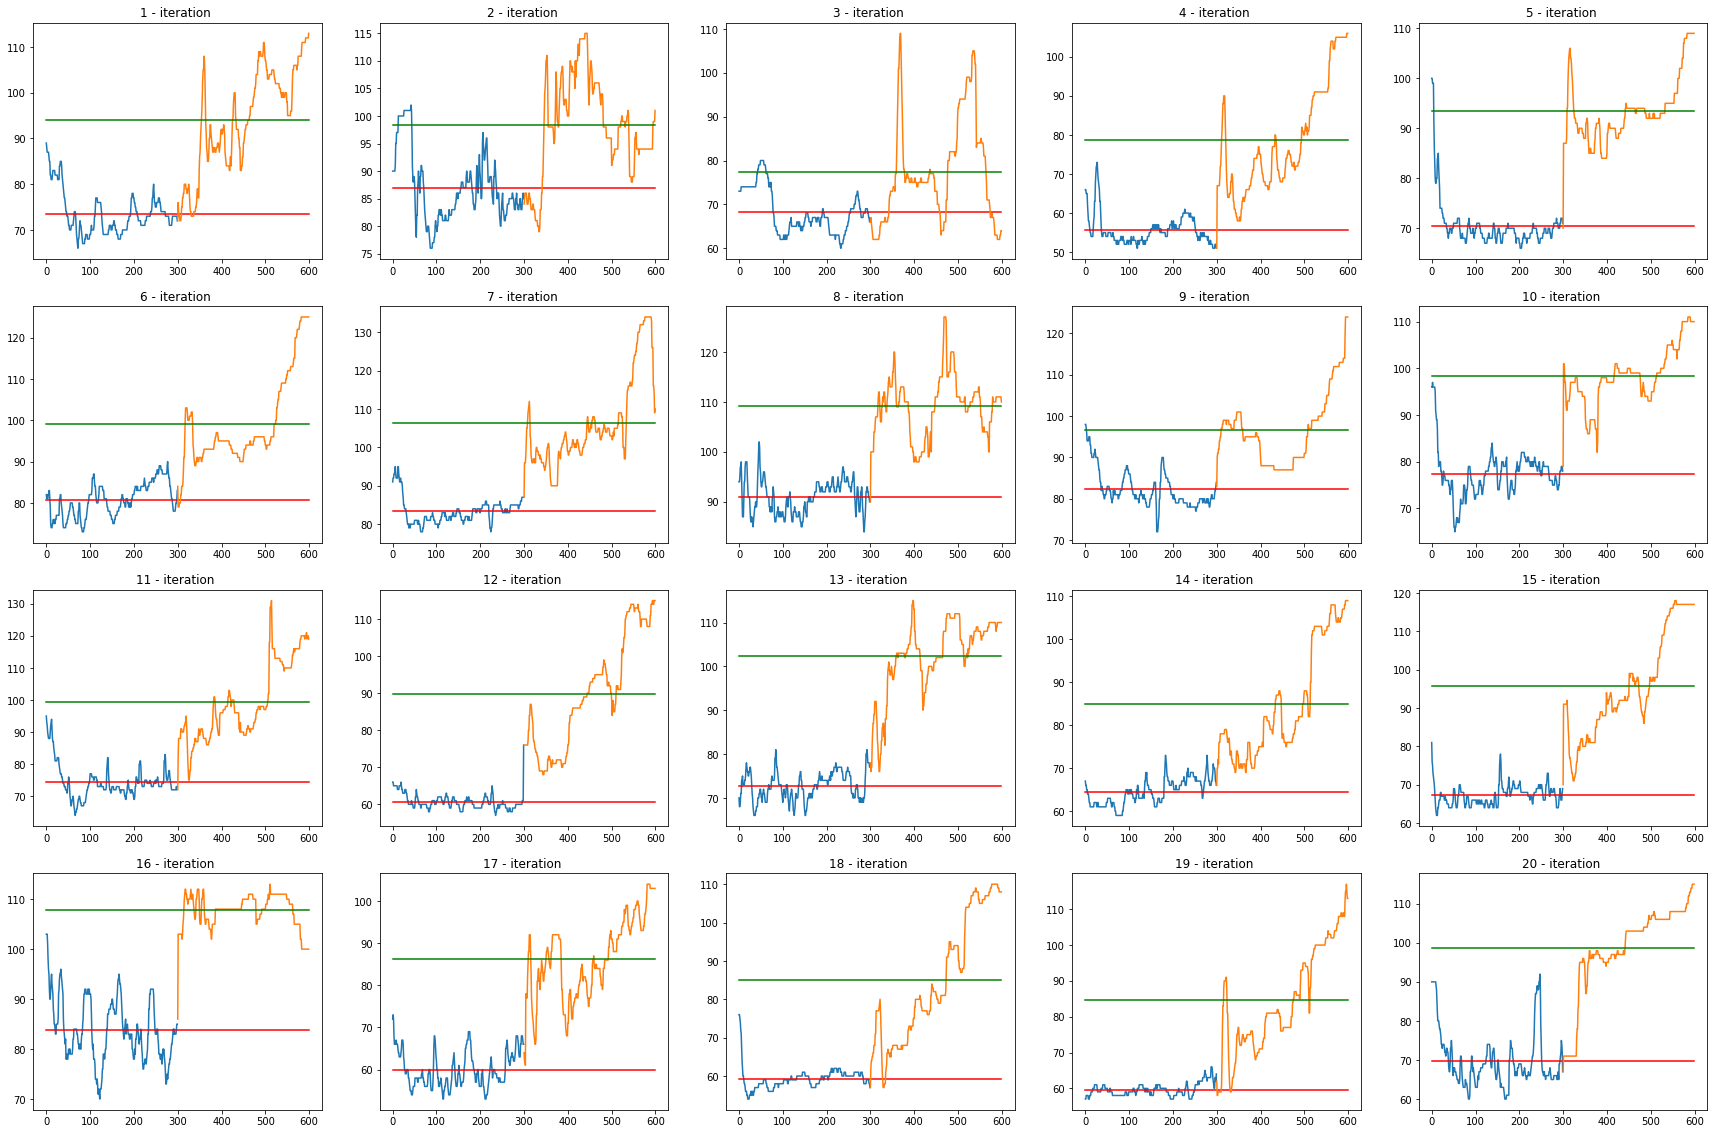

In [ ]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 4, ncols = 5)
medium_ratios = np.array([])

for counter, k in enumerate(indexes_neuro):

    ax[(counter) // 5][counter % 5].plot(neuro_data[k][:300],    label = 'First Relax Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(600) * neuro_data[k][:300].mean(), label = 'Mean Relax', color = 'Red')
    ax[(counter) // 5][counter % 5].plot(neuro_data[k][300:600], label = 'First Physical Work Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(600) * neuro_data[k][300:600].mean(), label = 'Mean Physical', color = 'Green')

    ax[(counter) // 5][counter % 5].set_title(indexes_neuro[counter] + ' - iteration ')
    medium_ratios = np.append(medium_ratios, neuro_data[k][300:600].mean() / neuro_data[k][:300].mean())

print('Physical heart rate approximately greater than relax in ', medium_ratios.mean(), '+-', medium_ratios.var())

#### First Relax vs First Emotional Stress period ECG

Emotional Stress rate approximately greater than relax in  1.1562361213668069 +- 0.015159364872955397


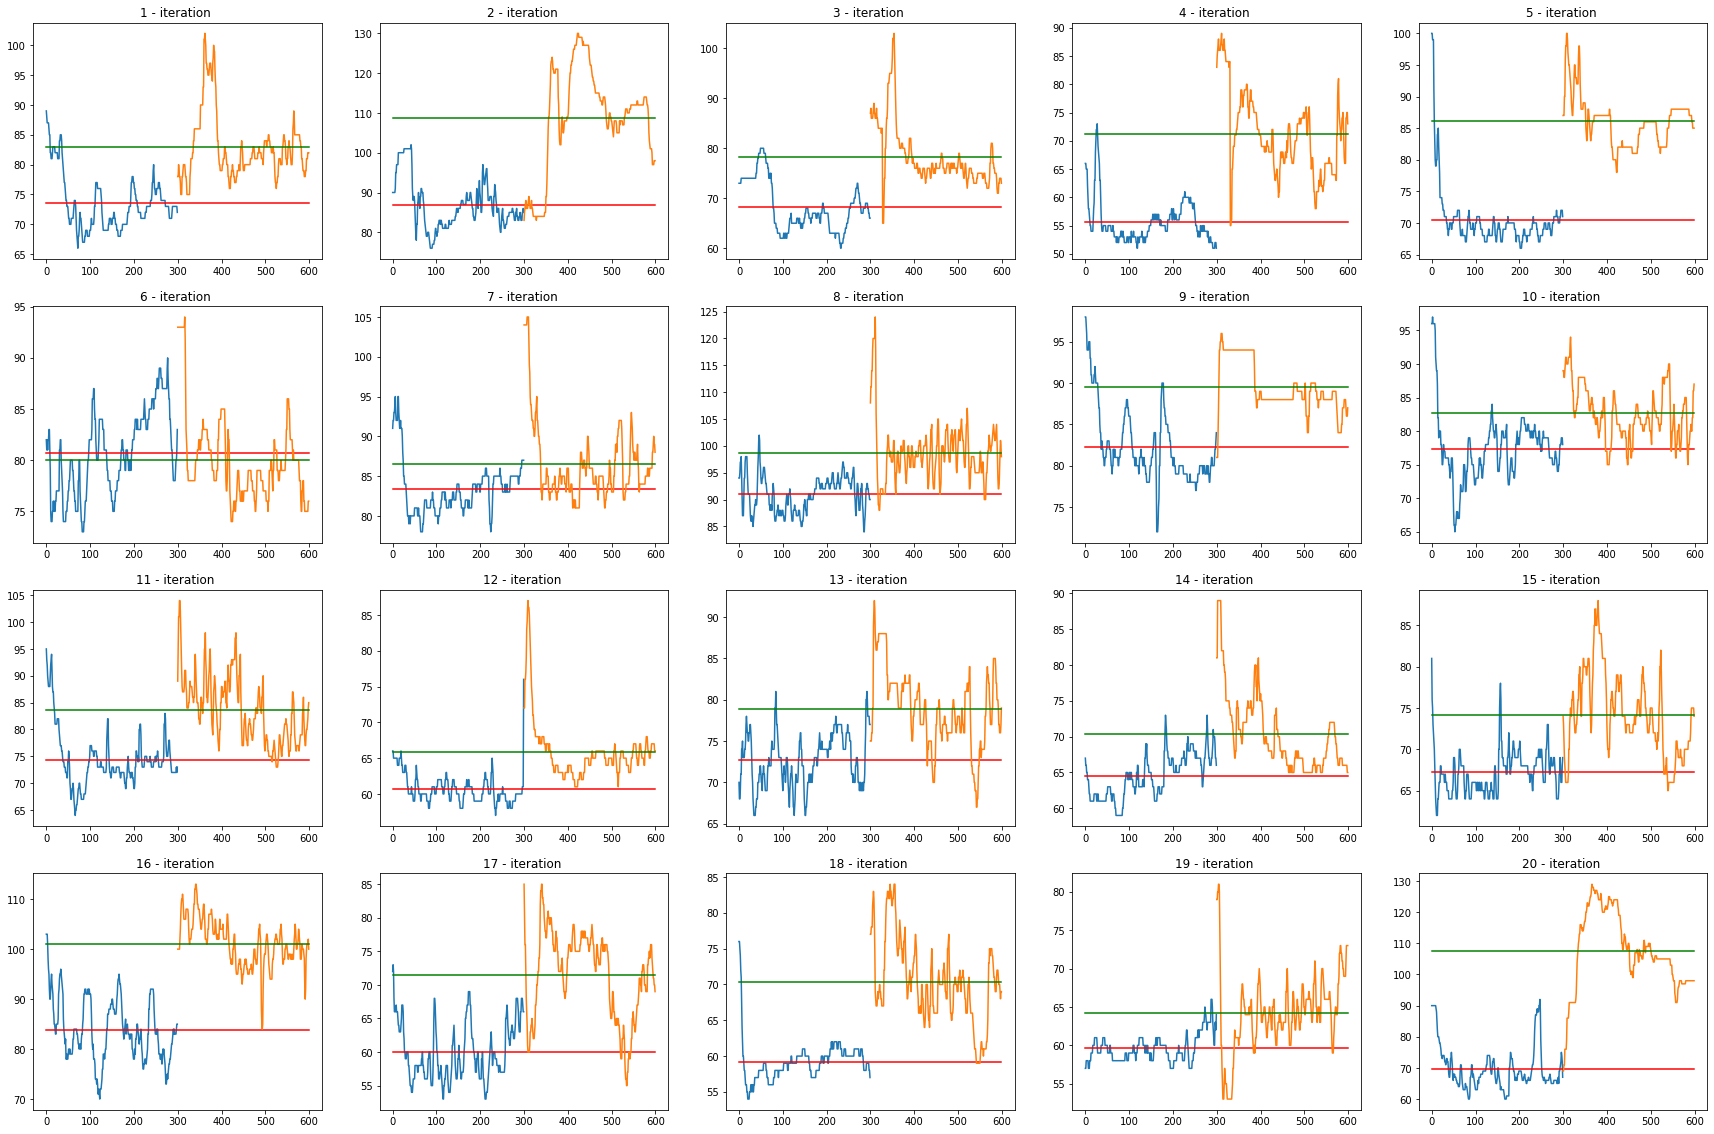

In [ ]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 4, ncols = 5)
medium_ratios = np.array([])

for counter, k in enumerate(indexes_neuro):

    ax[(counter) // 5][counter % 5].plot(np.arange(300), neuro_data[k][:300],    label = 'First Relax Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(600) * neuro_data[k][:300].mean(), label = 'Mean Relax', color = 'Red')
    ax[(counter) // 5][counter % 5].plot(np.arange(300, 600), neuro_data[k][940:1240], label = 'First Stress Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(600) * neuro_data[k][940:1240].mean(), label = 'Mean Stress', color = 'Green')
    ax[(counter) // 5][counter % 5].set_title(indexes_neuro[counter] + ' - iteration ')

    medium_ratios = np.append(medium_ratios, neuro_data[k][300:600].mean() / neuro_data[k][940:1240].mean())
print('Emotional Stress rate approximately greater than relax in ', medium_ratios.mean(), '+-', medium_ratios.var())

#### First Relax vs Second Emotional Stress period ECG

Emotional Stress rate approximately greater than relax in  1.3101854361300345 +- 0.014729637972761955


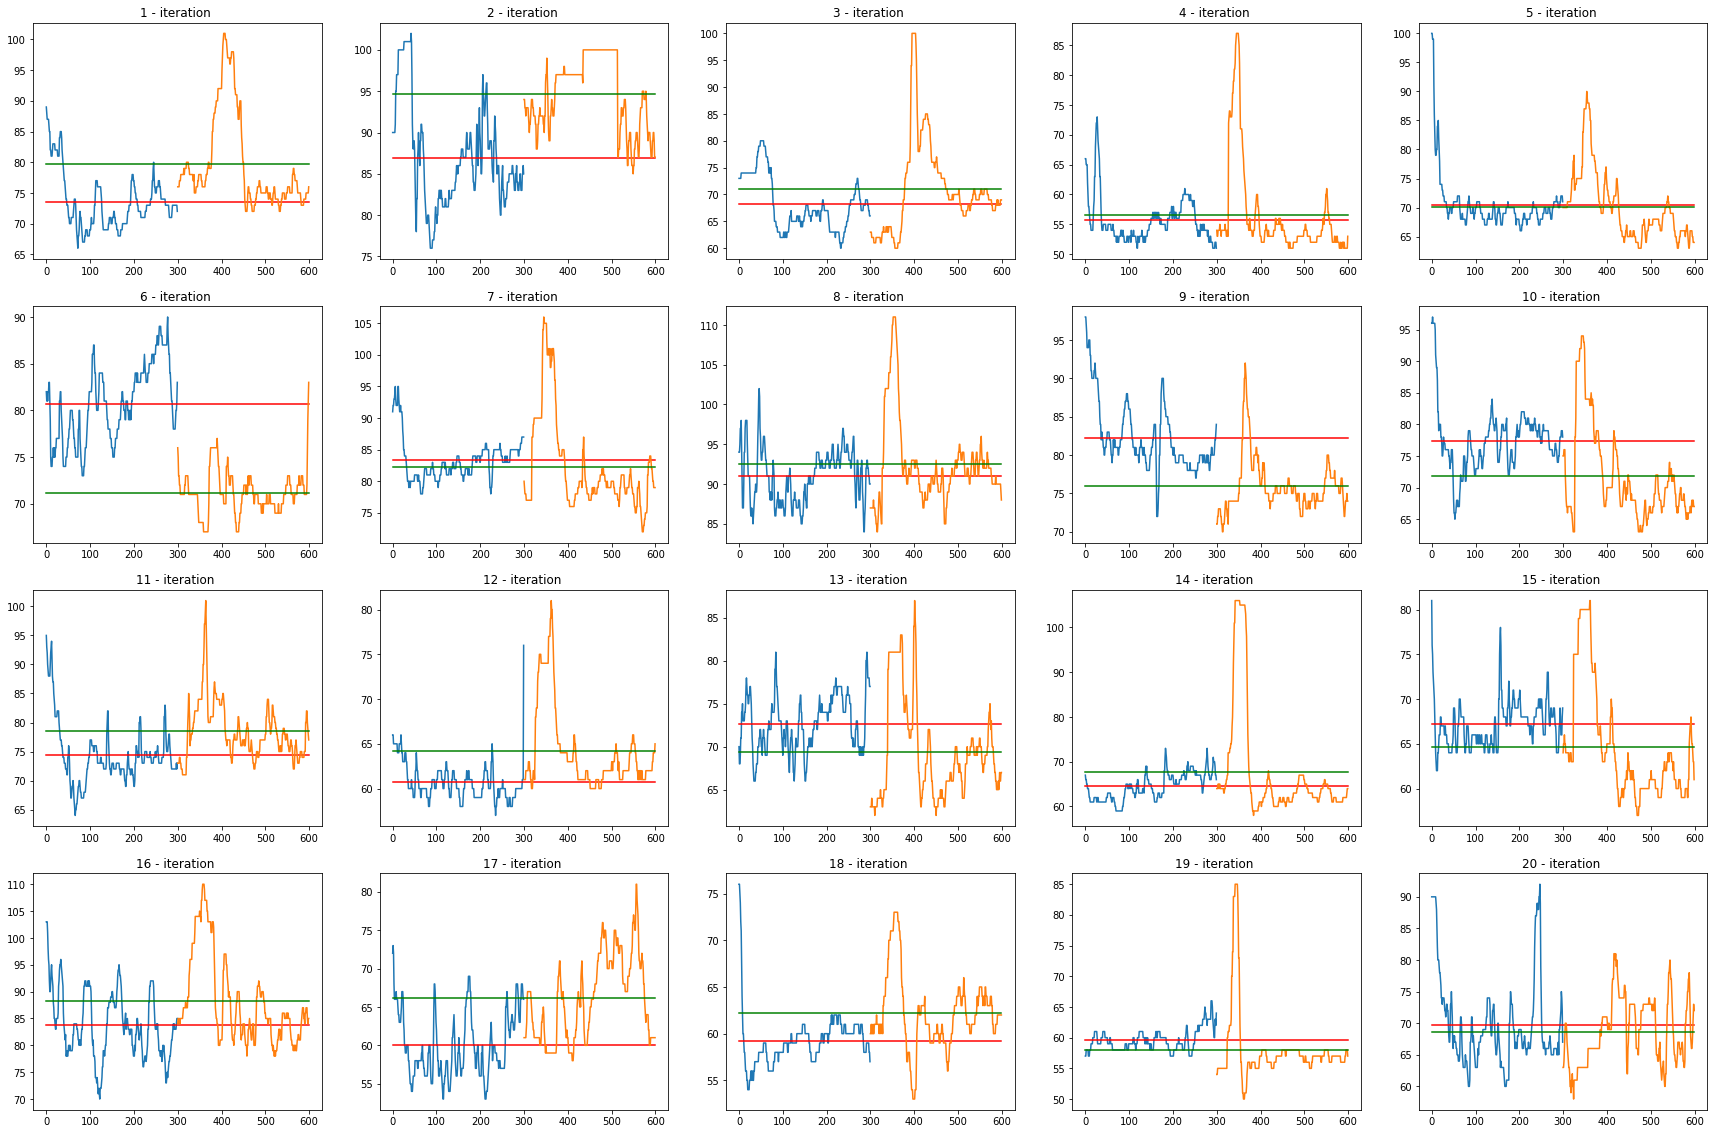

In [ ]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 4, ncols = 5)
medium_ratios = np.array([])

for counter, k in enumerate(indexes_neuro):

    ax[(counter) // 5][counter % 5].plot(np.arange(300), neuro_data[k][:300],            label = 'First Relax Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(600) * neuro_data[k][:300].mean(),      label = 'Mean Relax', color = 'Red')
    ax[(counter) // 5][counter % 5].plot(np.arange(300, 600), neuro_data[k][1600:1900],  label = 'Second Stress Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(600) * neuro_data[k][1600:1900].mean(), label = 'Mean Stress', color = 'Green')
    ax[(counter) // 5][counter % 5].set_title(indexes_neuro[counter] + ' - iteration ')

    medium_ratios = np.append(medium_ratios, neuro_data[k][300:600].mean() / neuro_data[k][1600:1900].mean())
    
print('Emotional Stress rate approximately greater than relax in ', medium_ratios.mean(), '+-', medium_ratios.var())

#### First Relax VS Second Relax VS Third Relax Periods

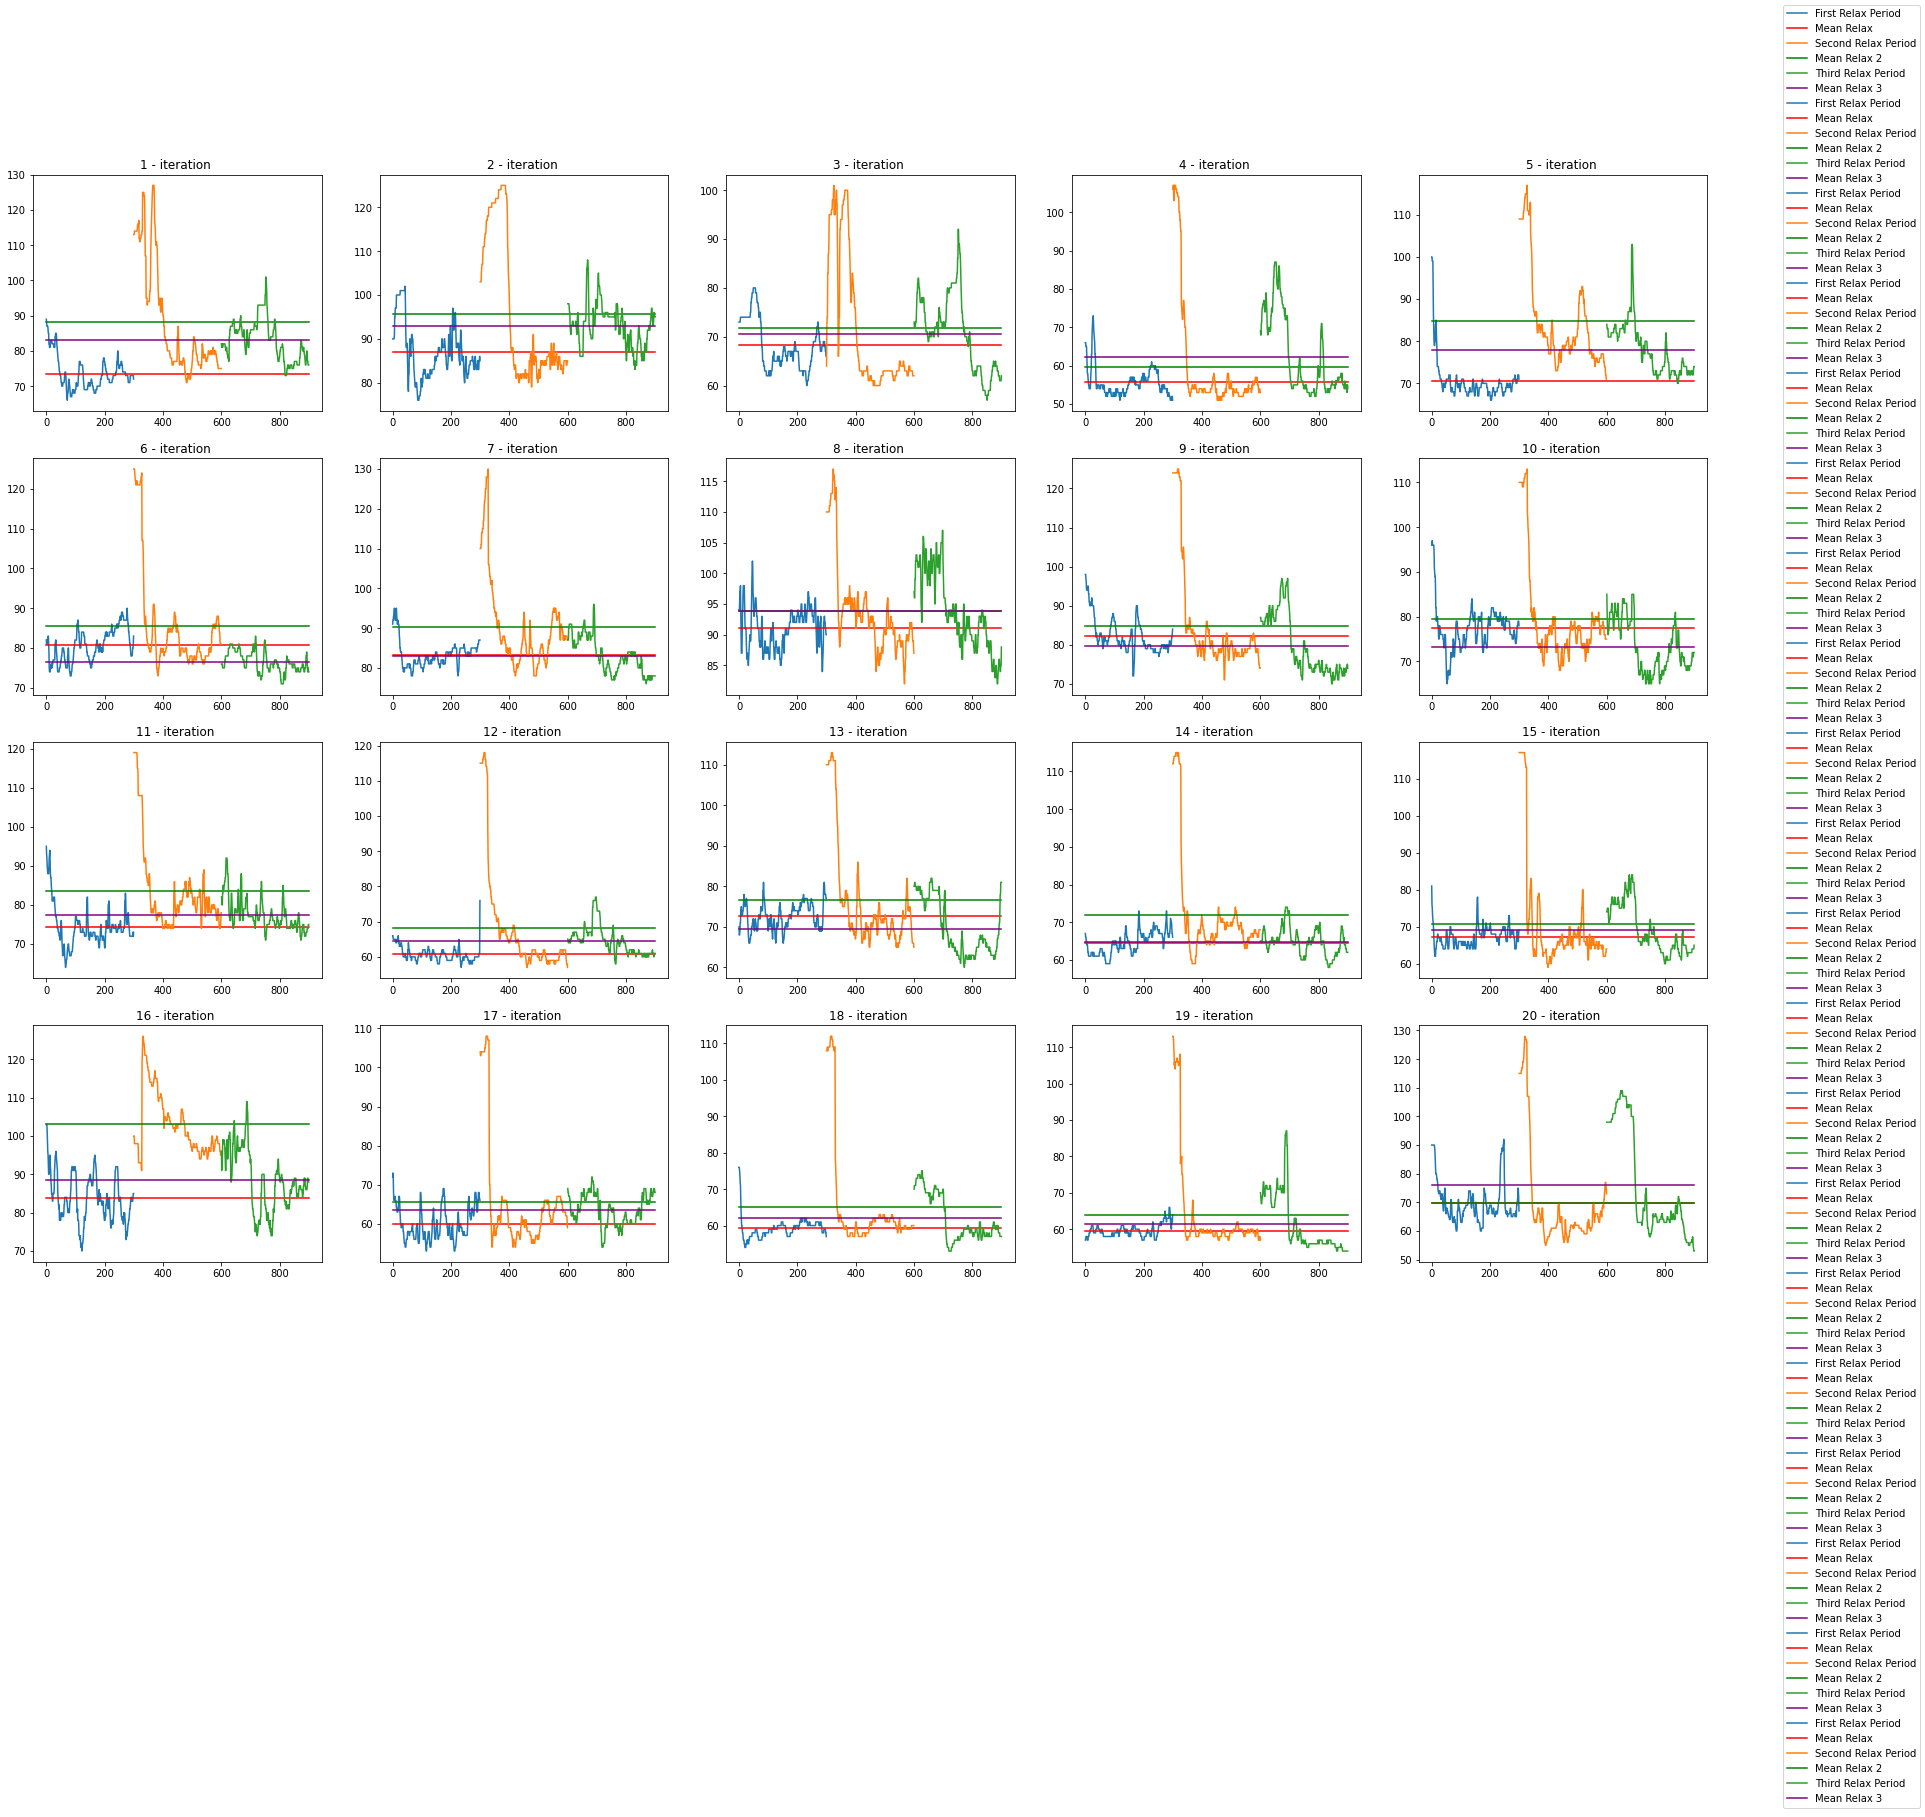

In [ ]:
fig, ax = plt.subplots(figsize = (30, 20), nrows = 4, ncols = 5)

for counter, k in enumerate(indexes_neuro):

    ax[(counter) // 5][counter % 5].plot(np.arange(300), neuro_data[k][:300],            label = 'First Relax Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(900) * neuro_data[k][:300].mean(),      label = 'Mean Relax', color = 'Red')
    ax[(counter) // 5][counter % 5].plot(np.arange(300, 600), neuro_data[k][600:900],    label = 'Second Relax Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(900) * neuro_data[k][600:900].mean(),   label = 'Mean Relax 2', color = 'Green')
    ax[(counter) // 5][counter % 5].plot(np.arange(600, 900), neuro_data[k][1240:1540],  label = 'Third Relax Period')
    ax[(counter) // 5][counter % 5].plot(np.ones(900) * neuro_data[k][1240:1540].mean(), label = 'Mean Relax 3', color = 'Purple')
    ax[(counter) // 5][counter % 5].set_title(indexes_neuro[counter] + ' - iteration ')
fig.legend()

That's nearly obviously that before all sorts of triggers heart rate was the lowest during the experiment. And for the most of people in that experiment it's proven by the diagram above